# Providing Data Driven Suggestions for Employee Retention
### Business Scenario
The HR department at Salifort Motors wants to take some initiatives to improve employee satisfaction levels at the company. They collected data from employees, but now they don’t know what to do with it. They refer to you as a data analytics professional and ask you to provide data-driven suggestions based on your understanding of the data. They have the following question: what’s likely to make the employee leave the company?

Your goals in this project are to analyze the data collected by the HR department and to build a model that predicts whether or not an employee will leave the company.

If you can predict employees likely to quit, it might be possible to identify factors that contribute to their leaving. Because it is time-consuming and expensive to find, interview, and hire new employees, increasing employee retention will be beneficial to the company.

### Understanding the Problem
Our stakeholders for this project are the Salifort Motors HR and management teams. We need to answer what factors make an employee more likely to leave Salifort Motors, and create a machine learning model that can predict whether an employee will leave the company or not.

We are solving a binary classification problem, where there are two outcomes: An employee will leave the company, or has stayed with the company. To solve these questions, we have been given a labeled dataset to explore and train a supervised machine learning model on.

Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

It's important to note that our outcome variable "left" does not distinguish between employees who quit and those who are let go by management.

To answer our business problem, we will go through the following steps:
- Perform Exploratory Data Analysis on the dataset
- Conduct Hypothesis Tests to determine statistical significance of variables
- Create and evaluate machine learning models to classify data
- Summarize our conclusions and results to provide actionable insights and recommendations

There will be two deliverables produced for the project; this python code notebook, and a one-page executive summary going over the results and conclusions.

Before we start with the first step of EDA, we must import the python packages and functions that will be used throughout the notebook.

In [2]:
# Data processing
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Tests
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Model data processing
from sklearn.model_selection import GridSearchCV, train_test_split

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance

# Model Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

## Exploratory Data Analysis

Our first step will be to load the data from a CSV file and take a quick look at the first few rows.

In [3]:
# Import data from csv file
data = pd.read_csv('HR_capstone_dataset.csv')

data.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


No obvious errors or problems with the data shown. Let's look over the column names.

In [4]:
data.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

There is some inconsistency with the casing of our column labels, and one typo. We could also rename "time_spend_company" and "promotion_last_5years" to increase their brevity.

In [5]:
# Update column names to snake_case, fix typos, increase brevity
data = data.rename(columns = {
    'average_montly_hours': 'average_monthly_hours',
    'time_spend_company': 'tenure',
    'Work_accident': 'work_accident',
    'Department': 'department'
})
data.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

We'll use the info() function to get an overview of the column's data types and missing values.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_monthly_hours  14999 non-null  int64  
 4   tenure                 14999 non-null  int64  
 5   work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


We have a total of 14,999 rows of data, and no missing values. Satisfaction_level and last_evaluation are floats on a scale from 0 to 1. We should make sure all their values are within that range. Department and salary are both string objects. The remaining columns are integers.

Next, we'll check for duplicate rows in the data.

In [7]:
data.duplicated().sum()

3008

In [8]:
# Display duplicate rows with satisfaction_level = 0.09, sort by last_evaluation
data[(data.duplicated(keep=False)) & (data['satisfaction_level'] == 0.09)].sort_values(by='last_evaluation')

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
30,0.09,0.62,6,294,4,0,1,0,accounting,low
12030,0.09,0.62,6,294,4,0,1,0,accounting,low
14241,0.09,0.62,6,294,4,0,1,0,accounting,low
12071,0.09,0.77,5,275,4,0,1,0,product_mng,medium
14863,0.09,0.77,6,290,4,0,1,0,technical,medium
...,...,...,...,...,...,...,...,...,...,...
454,0.09,0.97,7,254,4,1,1,0,RandD,medium
14665,0.09,0.97,7,254,4,1,1,0,RandD,medium
12332,0.09,0.98,6,271,4,0,1,0,sales,low
332,0.09,0.98,6,271,4,0,1,0,sales,low


Looks like there are in fact duplicate rows. With so many columns of data and each row representing an individual employee, it's highly unlikely any two rows would have the exact same values. We will drop these duplicates.

In [9]:
data = data.drop_duplicates()
data.shape

(11991, 10)

### Outliers
Next, let's look into potential outliers in our dataset. To get an idea of outliers, we can create box plots for each continuous variable.

Text(0.5, 0, 'Satisfaction Level')

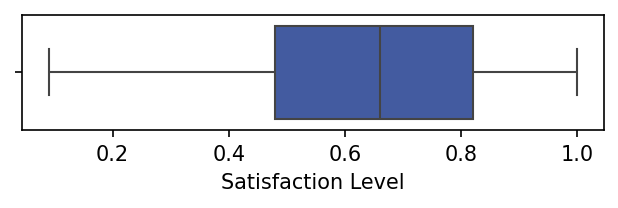

In [10]:
plt.figure(figsize = (5, 1), dpi = 150)
sns.boxplot(x = data['satisfaction_level'], color = '#3354b0')
plt.xlabel('Satisfaction Level')

Text(0.5, 0, 'Last Evaluation Score')

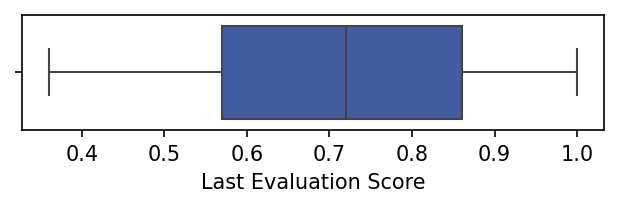

In [11]:
plt.figure(figsize = (5, 1), dpi = 150)
sns.boxplot(x = data['last_evaluation'], color = '#3354b0')
plt.xlabel('Last Evaluation Score')

Text(0.5, 0, '# of Projects Contributed To')

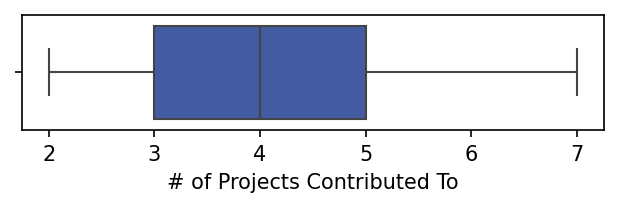

In [12]:
plt.figure(figsize = (5, 1), dpi = 150)
sns.boxplot(x = data['number_project'], color = '#3354b0')
plt.xlabel('# of Projects Contributed To')

Text(0.5, 0, 'Average Monthly Work Hours')

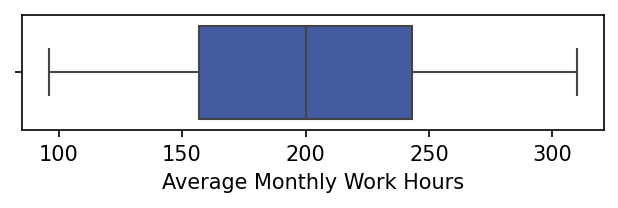

In [13]:
plt.figure(figsize = (5, 1), dpi = 150)
sns.boxplot(x = data['average_monthly_hours'], color = '#3354b0')
plt.xlabel('Average Monthly Work Hours')

Text(0.5, 0, 'Tenure (Years)')

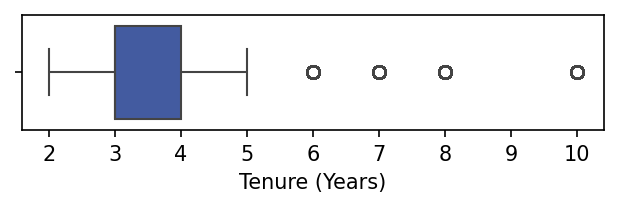

In [14]:
plt.figure(figsize = (5, 1), dpi = 150)
sns.boxplot(x = data['tenure'], color = '#3354b0')
plt.xlabel('Tenure (Years)')

Only Tenure contains statistical outliers. We have no reason to believe these outliers are erroneous or extreme. Because our objective is to make predictions about all employees at Salifort Motors, we should keep the rows that contain outliers in the Tenure column. Dropping them would result in our data only analyzing employees with 5 years of tenure or less, creating unwanted bias in its predictions.

### Discovery
Let's use the describe() function to look at summary statistics for our numeric columns.

In [15]:
data.describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years
count,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000
mean,0.629658,0.716683,3.802852,200.473522,3.364857,0.154282,0.166041,0.016929
std,0.241070,0.168343,1.163238,48.727813,1.330240,0.361234,0.372133,0.129012
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.480000,0.570000,3.000000,157.000000,3.000000,0.000000,0.000000,0.000000
50%,0.660000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.860000,5.000000,243.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


We can confirm again that there are no missing values in our numeric columns. All values within satisfaction_level and last_evaluation are within the correct range.

It appears that the minimum number of projects an employee at Salifort Motors contributes to is 2 projects. The most any employee contributes to is 7 projects. The average is close to 4 projects.

Average monthly hours for employees ranges from 96 hours to 310 hours, with a mean of 200 hours. 200 / 4 = 50; which means the average Salifort employee has a 50 hour work week, 10 above the standard 40 hour work week.

Tenure at Salifort ranges from 2 to 10 years, and most employees have been with the company around 3.5 years.

Next, we'll take a look at the string object columns "department" and "salary".

#### Department

Grouping our data by department may lead to some valuable insights. There may be ways to improve retention that are only applicable to a certain department within the company.

In [16]:
print(data['department'].value_counts())

# Display value counts as a percentage of total rows
print(data['department'].value_counts(normalize = True))

department
sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: count, dtype: int64
department
sales          0.270119
technical      0.187140
support        0.151864
IT             0.081394
RandD          0.057877
product_mng    0.057210
marketing      0.056125
accounting     0.051789
hr             0.050121
management     0.036361
Name: proportion, dtype: float64


The largest department is Sales, which has 27% of the employees in our dataset. The next largest departments are Technical and Support, which have 18.7% and 15.2% of employees. The smallest department is Management, with only 3.6% of employees.

I'm interested in seeing if there is a noticable difference in reported satisfaction between departments.

In [17]:
# Group data by department and display average values for numeric columns
data.groupby('department').mean(numeric_only = True)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years
department,,,,,,,,
IT,0.634016,0.715051,3.797131,200.638320,3.350410,0.142418,0.161885,0.002049
RandD,0.627176,0.712983,3.850144,201.291066,3.319885,0.171470,0.122478,0.030259
accounting,0.607939,0.721900,3.834138,200.877617,3.404187,0.140097,0.175523,0.016103
hr,0.621947,0.715691,3.675541,199.371048,3.256240,0.133111,0.188020,0.018303
management,0.631995,0.726307,3.837156,201.529817,3.981651,0.165138,0.119266,0.082569
marketing,0.634770,0.718440,3.720654,199.487370,3.421991,0.160475,0.166419,0.040119
product_mng,0.629825,0.713790,3.794461,198.893586,3.341108,0.158892,0.160350,0.000000
sales,0.631349,0.710398,3.777092,200.242050,3.380673,0.153751,0.169805,0.017907
support,0.634822,0.722998,3.820977,200.627128,3.292696,0.164195,0.171334,0.008786


There are no huge outliers in the means of our data between departments. Interestingly, Accounting has the lowest average reported satisfaction level.

Since that didn't produce big leads, let's continue our analysis by looking at the Salary column.

#### Salary

In [18]:
print(data['salary'].value_counts())

print(data['salary'].value_counts(normalize = True))

salary
low       5740
medium    5261
high       990
Name: count, dtype: int64
salary
low       0.478692
medium    0.438746
high      0.082562
Name: proportion, dtype: float64


The salary column is split into three categories; low, medium, and high. We do not know the specific values that define these categories.
- 47.9% of employees have a "low" salary.
- 43.9% of employees have a "medium" salary.
- Only 8.3% of employees have a "high" salary.

I am interested in the breakdown of these values between departments. Let's find a way to show the percentage of salaries for each department.

Since we are comparing two categorical variables, we can create a pivot table to compare their values. First we calculate the counts between categories, and then find the percentage of each salary level per department.

In [19]:
# Create a table that shows a breakdown of salary levels by department
pivot = data.pivot_table(index = 'salary', columns = 'department', aggfunc = 'size', sort = False).iloc[::-1]
pivot

department,sales,accounting,hr,technical,support,management,IT,product_mng,marketing,RandD
salary,,,,,,,,,,
high,237,63,38,166,126,128,71,52,62,47
medium,1449,262,267,940,828,169,429,291,301,325
low,1553,296,296,1138,867,139,476,343,310,322


In [20]:
# Create a table that shows percentage breakdown of salary by department
pivot = pivot.div(pivot.sum(axis = 0), axis = 1) * 100
pivot

department,sales,accounting,hr,technical,support,management,IT,product_mng,marketing,RandD
salary,,,,,,,,,,
high,7.317073,10.144928,6.322795,7.397504,6.919275,29.357798,7.274590,7.580175,9.212481,6.772334
medium,44.736030,42.190016,44.425957,41.889483,45.469522,38.761468,43.954918,42.419825,44.725111,46.829971
low,47.946897,47.665056,49.251248,50.713012,47.611203,31.880734,48.770492,50.000000,46.062407,46.397695


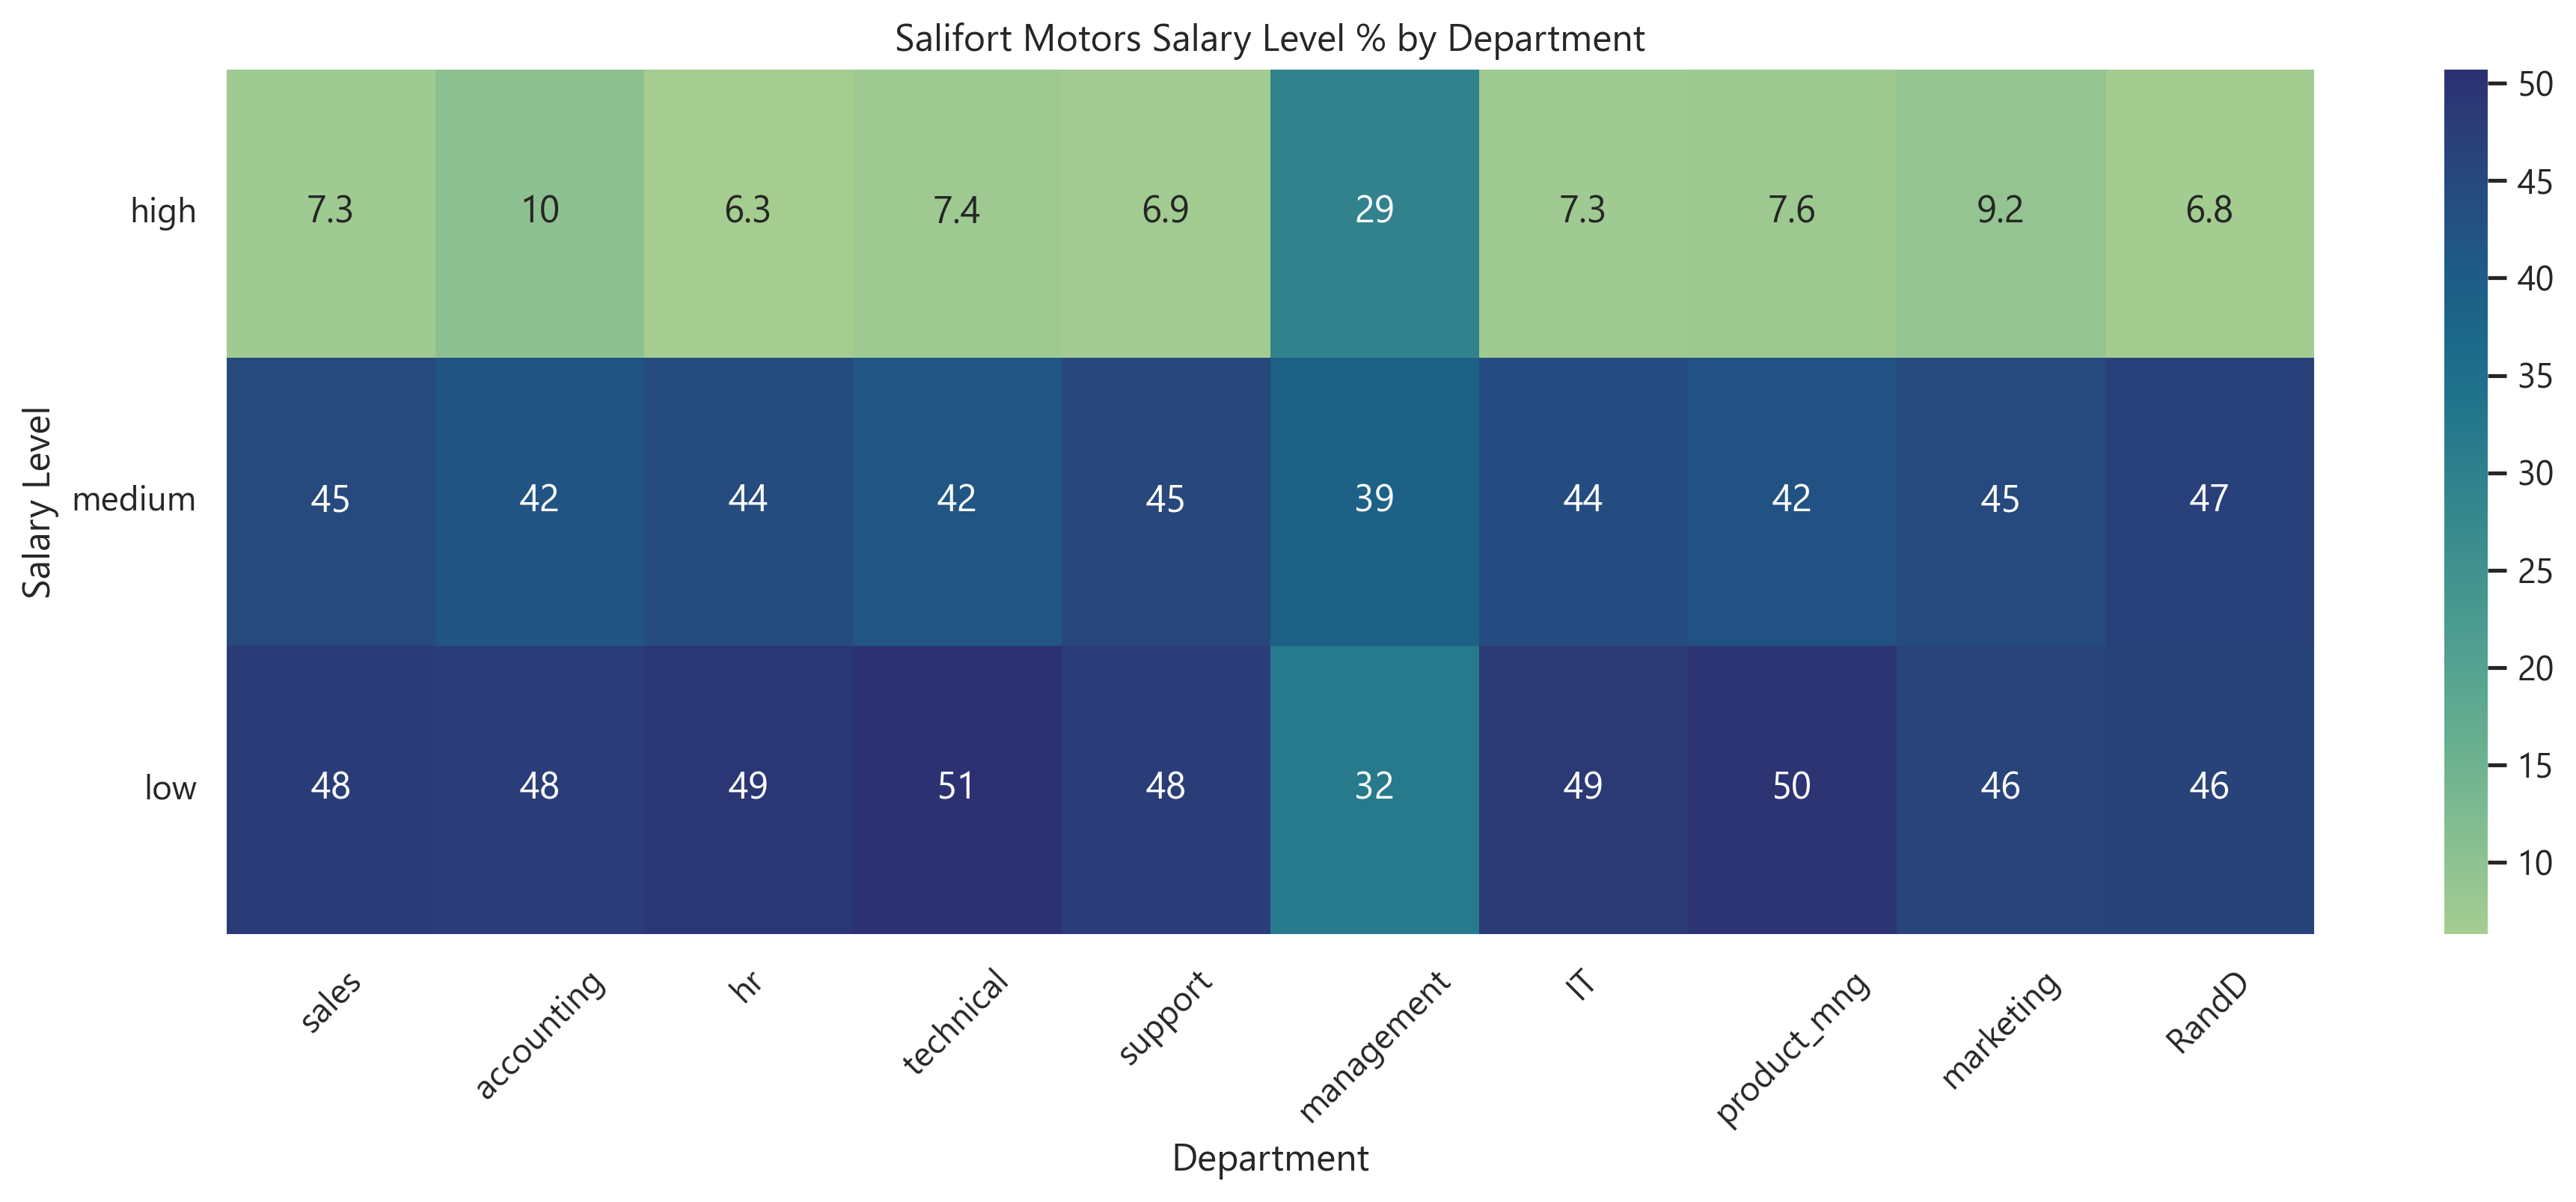

In [21]:
# Create a heatmap plot of salary level percentage by department
plt.figure(figsize = (15, 5), dpi = 300)
sns.set_theme(font = 'Segoe UI')
sns.heatmap(pivot, annot = True, cmap = 'crest')

plt.title('Salifort Motors Salary Level % by Department')

plt.ylabel('Salary Level')
plt.yticks(rotation = 'horizontal')

plt.xlabel('Department')
plt.xticks(rotation = 45)

plt.show()

As we would expect, management has the highest percentage of high salary level. Accounting and Marketing have the next highest percentage of high salaries. The Technical and Product Management departments have the highest low salary percentages. The lowest percentage of high salaries is within the HR department.

#### Work Accidents and Promotions

Next, let's look at the boolean columns "work_accident" and "promotion_last_5years".

In [22]:
print(data['work_accident'].value_counts())

print(data['work_accident'].value_counts(normalize = True))

work_accident
0    10141
1     1850
Name: count, dtype: int64
work_accident
0    0.845718
1    0.154282
Name: proportion, dtype: float64


15.4% of employees in our dataset have had a work-related accident.

I want to know if there's a department where workplace accidents are more common.

In [23]:
pivot = data.pivot_table(index = 'work_accident', columns = 'department', aggfunc = 'size')
pivot.div(pivot.sum(axis = 0), axis = 1) * 100

department,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
work_accident,,,,,,,,,,
0,85.758197,82.853026,85.990338,86.688852,83.486239,83.952452,84.110787,84.624884,83.58045,84.893048
1,14.241803,17.146974,14.009662,13.311148,16.513761,16.047548,15.889213,15.375116,16.41955,15.106952


Looks like R&D has the highest percentage of workplace accidents, and HR has the lowest percentage. That seems very plausible. There are no big outliers here.

In [24]:
print(data['promotion_last_5years'].value_counts())

print(data['promotion_last_5years'].value_counts(normalize = True))

promotion_last_5years
0    11788
1      203
Name: count, dtype: int64
promotion_last_5years
0    0.983071
1    0.016929
Name: proportion, dtype: float64


Only 1.7% of employees in our dataset have received a promotion within the last 5 years of their tenure.

In [25]:
pivot = data.pivot_table(index = 'promotion_last_5years', columns = 'department', aggfunc = 'size')
(pivot.div(pivot.sum(axis = 0), axis = 1) * 100).T

promotion_last_5years,0,1
department,,
IT,99.795082,0.204918
RandD,96.974063,3.025937
accounting,98.389694,1.610306
hr,98.169717,1.830283
management,91.743119,8.256881
marketing,95.988113,4.011887
product_mng,100.000000,NaN
sales,98.209324,1.790676
support,99.121362,0.878638


Management has the highest promotion rate at 8.3%. Nobody in the product management department has been given a promotion within the last 5 years.

#### Target Variable: "left"

As our last look at individual columns, let's see the values and class balance of our target variable "left". This column indicates whether an employee is still working for the company or not. It includes both employees who quit and those who were fired.

A value of 1 indicates the employee is no longer with the company.

In [26]:
print(data['left'].value_counts())

print(data['left'].value_counts(normalize = True))

left
0    10000
1     1991
Name: count, dtype: int64
left
0    0.833959
1    0.166041
Name: proportion, dtype: float64


In our dataset, 83.3% of employees still work at Salifort and 16.7% have left the company.

Let's see the average values of our numeric columns between employees who left and those who haven't.

In [27]:
avgs = data.groupby('left').mean(numeric_only = True)
avgs.T

left,0,1
satisfaction_level,0.667365,0.440271
last_evaluation,0.715667,0.721783
number_project,3.786800,3.883476
average_monthly_hours,198.942700,208.162230
tenure,3.262000,3.881467
work_accident,0.174500,0.052737
promotion_last_5years,0.019500,0.004018


- The average satisfaction level of employess who left the company is 44%, compared to 66% for those who have not left. Satisfaction level would be a good feature to investigate further.
- The average monthly hours of employees who left is 10 higher than those who have stayed.
- Employees who have left the company have an average tenure of 3.88 years, while current employees have an average tenure of 3.26 years.
- Only 5% of employees who left the company had a work-related accident. 17.5% of current employees have had a work-related accident.
- 0.4% of employees who left the company had received a promotion in the last 5 years. 2% of current employees have received a promotion in the last 5 years.
- Last evaluation score and number of projects contributed to seem roughly the same.

Let's see if we can gleam any insights by visualizing this data.

<Axes: xlabel='satisfaction_level', ylabel='Count'>

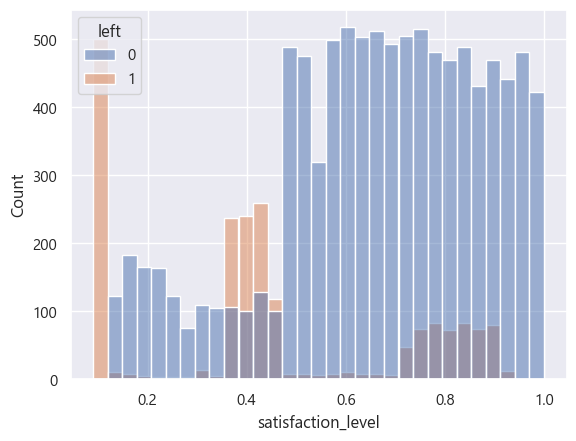

In [28]:
sns.histplot(x = data['satisfaction_level'], hue = data['left'])

Most employees who have stayed with the company have a satisfaction level above 0.5. There are three groups of satisfaction level for employees who left; some with a satisfaction level around 0.8, some around 0.4, and a spike of 0 satisfaction.

<Axes: xlabel='last_evaluation', ylabel='Count'>

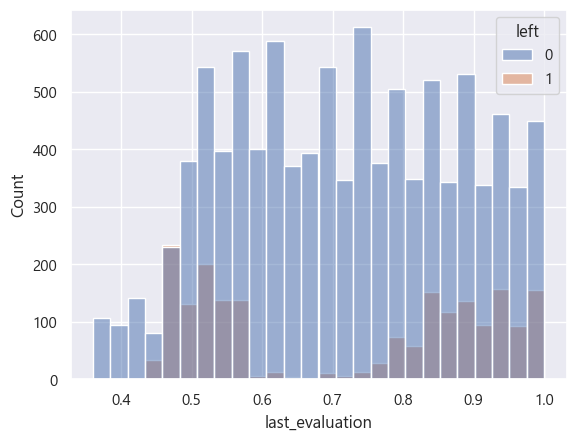

In [29]:
sns.histplot(x = data['last_evaluation'], hue = data['left'])

For last evaluation score, we see a similar distribution to satisfaction level from employees still with the company. For those who left, there are two groups; those with a high evaluation score and those with a low evaluation score.

<Axes: xlabel='number_project', ylabel='Count'>

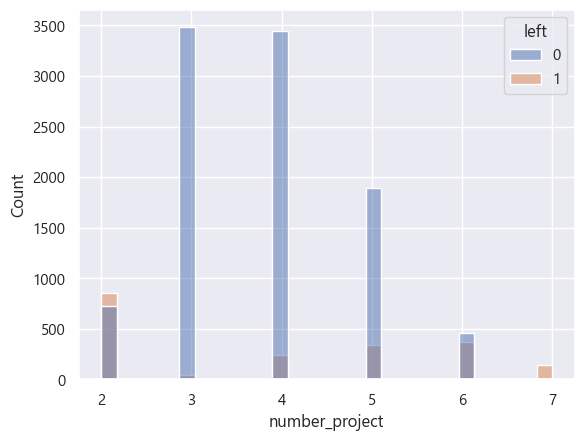

In [30]:
sns.histplot(x = data['number_project'], hue = data['left'])

- There are more employees who left the company and contributed to two projects than those who stayed and contributed to two projects. 
- Almost no employee who contributes to three projects has left the company.
- A majority of employees contribute to three, four, or five projects.
- There are an almost equal amount of employees who left or stayed that contributed to six projects.
- No employee who has contributed to seven projects has stayed with the company.

<Axes: xlabel='average_monthly_hours', ylabel='Count'>

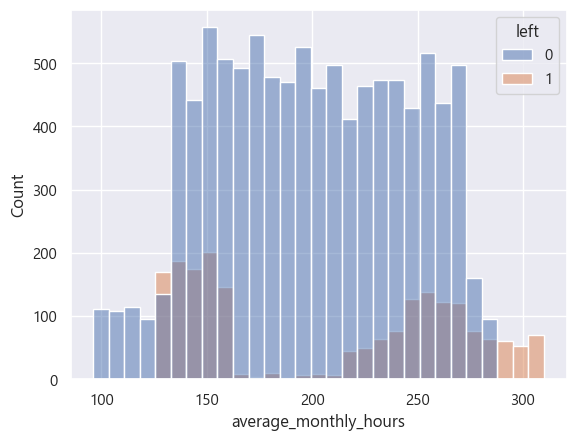

In [31]:
sns.histplot(x = data['average_monthly_hours'], hue = data['left'])

The distribution of average monthly hours is very similar to last evaluation score. No employee who has an average monthly work hours around 300 has stayed with the company.

I'm interested to see if there's a connection between average work hours, evaluation score, and number of projects contributed to for employees who left the company. Since this dataset does not differentiate between those who quit and those who were fired, the group we're seeing on the lower end may be employees who were let go by the company and were thus given reduced workload beforehand.

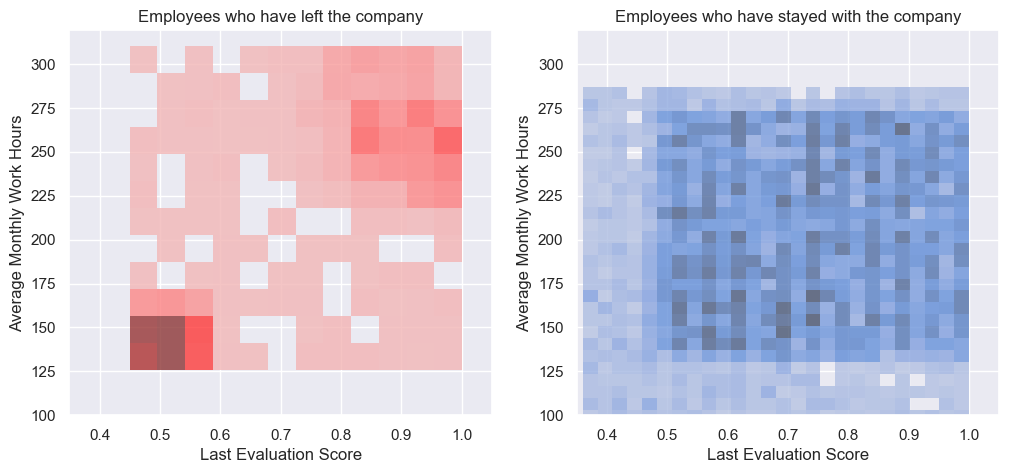

In [32]:
# Set style to darkgrid to see tick lines
sns.set_style('darkgrid')

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

# Heatmap of employees who left the company
sns.histplot(
    x = data[data['left'] == 1]['last_evaluation'], 
    y = data[data['left'] == 1]['average_monthly_hours'],
    color = 'red',
    ax = axes[0],
    alpha = 0.8
)
axes[0].set_xlabel('Last Evaluation Score')
axes[0].set_ylabel('Average Monthly Work Hours')
axes[0].set_title('Employees who have left the company')

# Heatmap of employees who stayed with the company
sns.histplot(
    x = data[data['left'] == 0]['last_evaluation'], 
    y = data[data['left'] == 0]['average_monthly_hours'],
    ax = axes[1],
    alpha = 0.8
)
axes[1].set_xlabel('Last Evaluation Score')
axes[1].set_ylabel('Average Monthly Work Hours')
axes[1].set_title('Employees who have stayed with the company')

# Set y scale
y_max = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
axes[0].set_ylim(100, y_max)
axes[1].set_ylim(100, y_max)

# Set x scale
axes[0].set_xlim(0.35, 1.05)
axes[1].set_xlim(0.35, 1.05)

# Display plot
plt.show()

We can see the two groups of employees who left the company on our left-side plot. One group is concentrated around high evaluation score and high hours, and another with very low evaluation score and very low hours. Looking at the graph of the same data for employees still with the company, we do not see the same grouping.

What if we limit our plots to only employees who contribute to two projects?

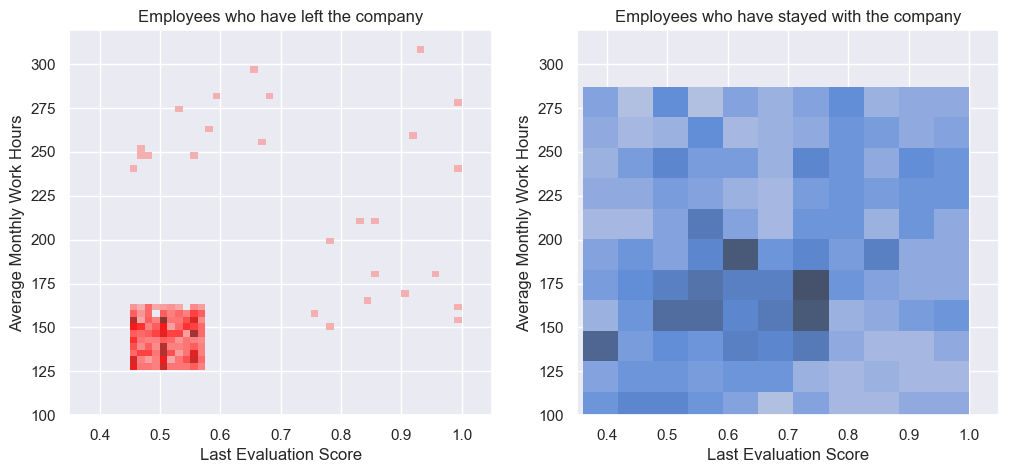

In [33]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))
sns.histplot(
    x = data[(data['left'] == 1) & (data['number_project'] == 2)]['last_evaluation'], 
    y = data[(data['left'] == 1) & (data['number_project'] == 2)]['average_monthly_hours'],
    color = 'red',
    ax = axes[0]
)
axes[0].set_xlabel('Last Evaluation Score')
axes[0].set_ylabel('Average Monthly Work Hours')
axes[0].set_title('Employees who have left the company')
sns.histplot(
    x = data[(data['left'] == 0) & (data['number_project'] == 2)]['last_evaluation'], 
    y = data[(data['left'] == 0) & (data['number_project'] == 2)]['average_monthly_hours'],
    ax = axes[1]
)
axes[1].set_xlabel('Last Evaluation Score')
axes[1].set_ylabel('Average Monthly Work Hours')
axes[1].set_title('Employees who have stayed with the company')

y_max = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
axes[0].set_ylim(100, y_max)
axes[1].set_ylim(100, y_max)

axes[0].set_xlim(0.35, 1.05)
axes[1].set_xlim(0.35, 1.05)
plt.show()

Here, the difference is more obvious. We can plainly see a group of employees who left the company that had a low evaluation score and low work hours. I believe this grouping represents employees who were let go due to poor performance.

What about the other group we saw?

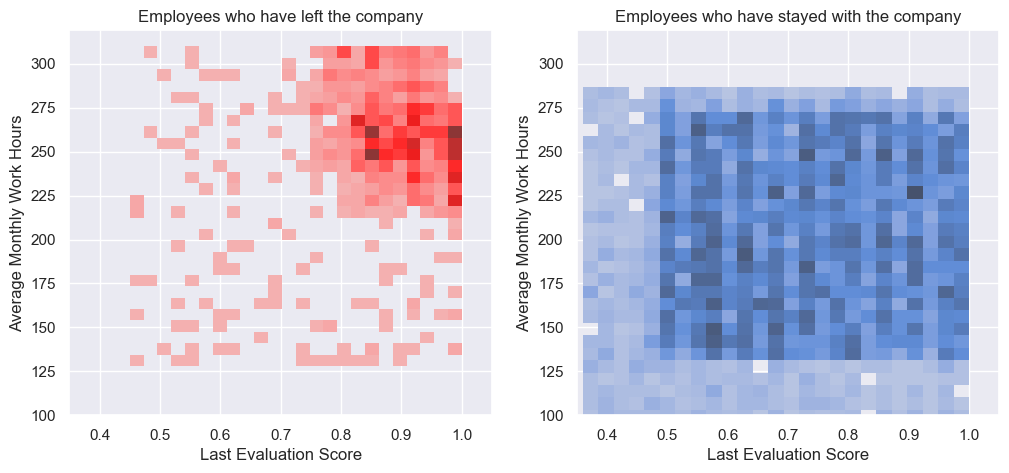

In [34]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))
sns.histplot(
    x = data[(data['left'] == 1) & (data['number_project'] != 2)]['last_evaluation'], 
    y = data[(data['left'] == 1) & (data['number_project'] != 2)]['average_monthly_hours'],
    color = 'red',
    ax = axes[0]
)
axes[0].set_xlabel('Last Evaluation Score')
axes[0].set_ylabel('Average Monthly Work Hours')
axes[0].set_title('Employees who have left the company')
sns.histplot(
    x = data[(data['left'] == 0) & (data['number_project'] != 2)]['last_evaluation'], 
    y = data[(data['left'] == 0) & (data['number_project'] != 2)]['average_monthly_hours'],
    ax = axes[1]
)
axes[1].set_xlabel('Last Evaluation Score')
axes[1].set_ylabel('Average Monthly Work Hours')
axes[1].set_title('Employees who have stayed with the company')

y_max = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
axes[0].set_ylim(100, y_max)
axes[1].set_ylim(100, y_max)

axes[0].set_xlim(0.35, 1.05)
axes[1].set_xlim(0.35, 1.05)
plt.show()

When we only look at employees who worked on three or more projects, the group we saw in the previous plot is not present. We do see the other group with high evaluation scores and high work hours. This group most likely represents employees who quit and found other companies to work for. They were able to leverage their performance to find other employment.

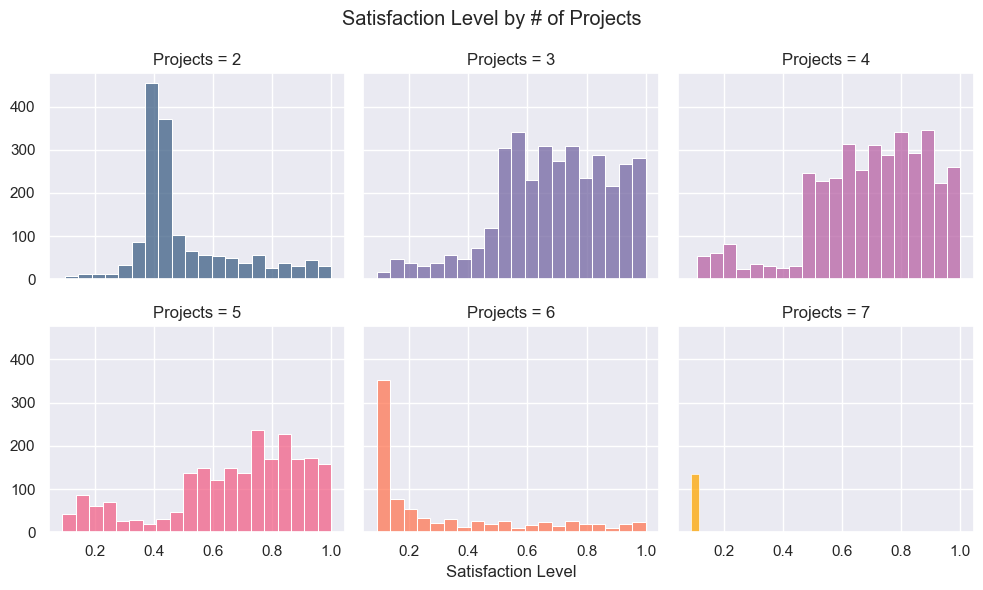

In [35]:
# Create a figure with six subplots; two rows of three plots that share the same scale
fig, axes = plt.subplots(2, 3, figsize = (10, 6), sharex = True, sharey = True)

# Create a histogram of satisfaction level from rows where number_project = 2
sns.histplot(x = data[data['number_project'] == 2]['satisfaction_level'], ax = axes[0][0], bins = 20, color = '#3e5f85')
axes[0][0].set_title('Projects = 2')

# Create a histogram of satisfaction level from rows where number_project = 3
sns.histplot(x = data[data['number_project'] == 3]['satisfaction_level'], ax = axes[0][1], bins = 20, color = '#7366a2')
axes[0][1].set_title('Projects = 3')

# Create a histogram of satisfaction level from rows where number_project = 4
sns.histplot(x = data[data['number_project'] == 4]['satisfaction_level'], ax = axes[0][2], bins = 20, color = '#b862a4')
axes[0][2].set_title('Projects = 4')

# Create a histogram of satisfaction level from rows where number_project = 5. Remove x label
sns.histplot(x = data[data['number_project'] == 5]['satisfaction_level'], ax = axes[1][0], bins = 20, color = '#f26187')
axes[1][0].set_title('Projects = 5')
axes[1][0].set_xlabel('')

# Create a histogram of satisfaction level from rows where number_project = 6. Keep x label
sns.histplot(x = data[data['number_project'] == 6]['satisfaction_level'], ax = axes[1][1], bins = 20, color = '#ff7855')
axes[1][1].set_title('Projects = 6')
axes[1][1].set_xlabel('Satisfaction Level')

# Create a histogram of satisfaction level from rows where number_project = 7. Remove x label
sns.histplot(x = data[data['number_project'] == 7]['satisfaction_level'], ax = axes[1][2], bins = 20, color = '#ffa600')
axes[1][2].set_title('Projects = 7')
axes[1][2].set_xlabel('')

# Set title
fig.suptitle('Satisfaction Level by # of Projects')
# Remove y axis labels
plt.setp(axes, ylabel = '')

plt.tight_layout()
plt.show()

- The satisfaction of those who work on two projects is relatively low.
- The satisfaction of those who work on three, four, or five projects has a similar distribution.
- The satisfaction of those who work on six or seven projects is very low.

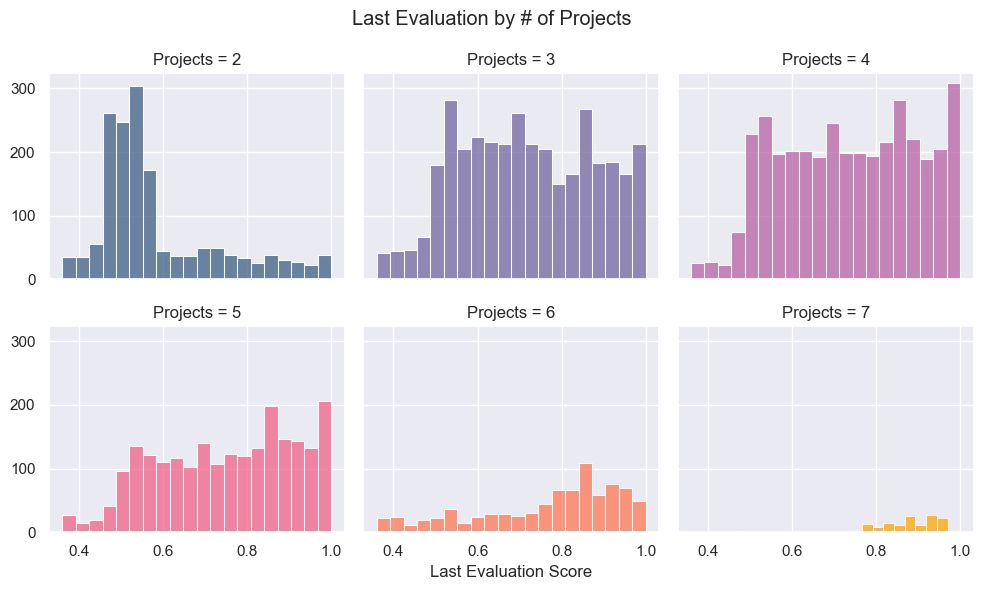

In [36]:
fig, axes = plt.subplots(2, 3, figsize = (10, 6), sharex = True, sharey = True)
sns.histplot(x = data[data['number_project'] == 2]['last_evaluation'], ax = axes[0][0], bins = 20, color = '#3e5f85')
axes[0][0].set_title('Projects = 2')

sns.histplot(x = data[data['number_project'] == 3]['last_evaluation'], ax = axes[0][1], bins = 20, color = '#7366a2')
axes[0][1].set_title('Projects = 3')

sns.histplot(x = data[data['number_project'] == 4]['last_evaluation'], ax = axes[0][2], bins = 20, color = '#b862a4')
axes[0][2].set_title('Projects = 4')

sns.histplot(x = data[data['number_project'] == 5]['last_evaluation'], ax = axes[1][0], bins = 20, color = '#f26187')
axes[1][0].set_title('Projects = 5')
axes[1][0].set_xlabel('')

sns.histplot(x = data[data['number_project'] == 6]['last_evaluation'], ax = axes[1][1], bins = 20, color = '#ff7855')
axes[1][1].set_title('Projects = 6')
axes[1][1].set_xlabel('Last Evaluation Score')

sns.histplot(x = data[data['number_project'] == 7]['last_evaluation'], ax = axes[1][2], bins = 20, color = '#ffa600')
axes[1][2].set_title('Projects = 7')
axes[1][2].set_xlabel('')

fig.suptitle('Last Evaluation by # of Projects')
plt.setp(axes, ylabel = '')
plt.tight_layout()
plt.show()

- The evaluation score of those who worked on two projects is relatively low. This supports our observations of the group we theorize were let go by the company.
- The evaluation score of those who worked on more than two projects has similar distributions.
- Those who worked on seven projects only have relatively high evaluation scores.

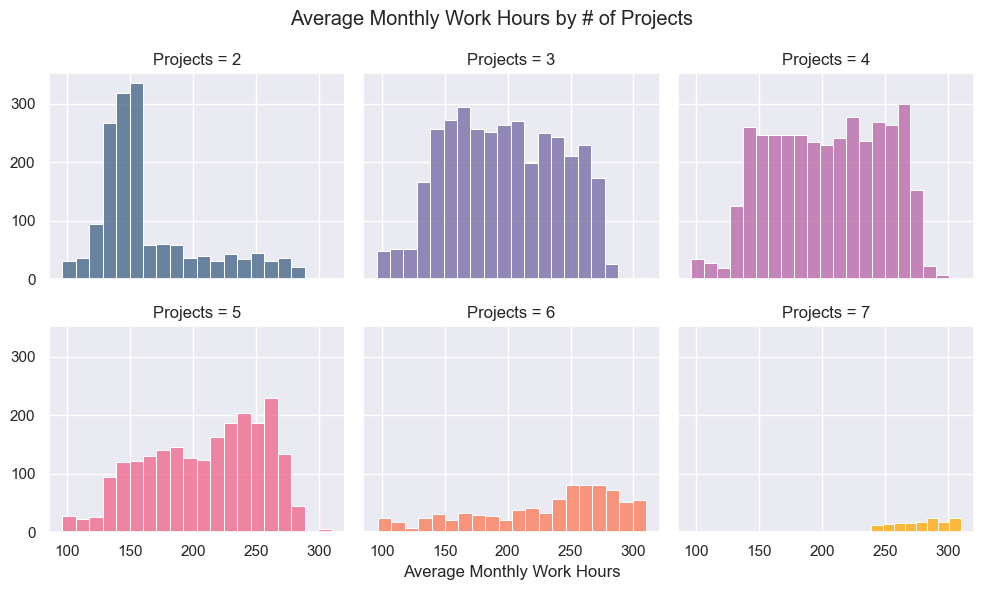

In [37]:
fig, axes = plt.subplots(2, 3, figsize = (10, 6), sharex = True, sharey = True)
sns.histplot(x = data[data['number_project'] == 2]['average_monthly_hours'], ax = axes[0][0], bins = 20, color = '#3e5f85')
axes[0][0].set_title('Projects = 2')

sns.histplot(x = data[data['number_project'] == 3]['average_monthly_hours'], ax = axes[0][1], bins = 20, color = '#7366a2')
axes[0][1].set_title('Projects = 3')

sns.histplot(x = data[data['number_project'] == 4]['average_monthly_hours'], ax = axes[0][2], bins = 20, color = '#b862a4')
axes[0][2].set_title('Projects = 4')

sns.histplot(x = data[data['number_project'] == 5]['average_monthly_hours'], ax = axes[1][0], bins = 20, color = '#f26187')
axes[1][0].set_title('Projects = 5')
axes[1][0].set_xlabel('')

sns.histplot(x = data[data['number_project'] == 6]['average_monthly_hours'], ax = axes[1][1], bins = 20, color = '#ff7855')
axes[1][1].set_title('Projects = 6')
axes[1][1].set_xlabel('Average Monthly Work Hours')

sns.histplot(x = data[data['number_project'] == 7]['average_monthly_hours'], ax = axes[1][2], bins = 20, color = '#ffa600')
axes[1][2].set_title('Projects = 7')
axes[1][2].set_xlabel('')

fig.suptitle('Average Monthly Work Hours by # of Projects')
plt.setp(axes, ylabel = '')
plt.tight_layout()
plt.show()

These distributions follow closely to those we saw from last evaluation score. Those who work on five, six, or seven projects have higher average monthly work hours and higher evaluation scores, but lower satisfaction levels. There may be correlation between these variables. Let's visualize that correlation to verify.

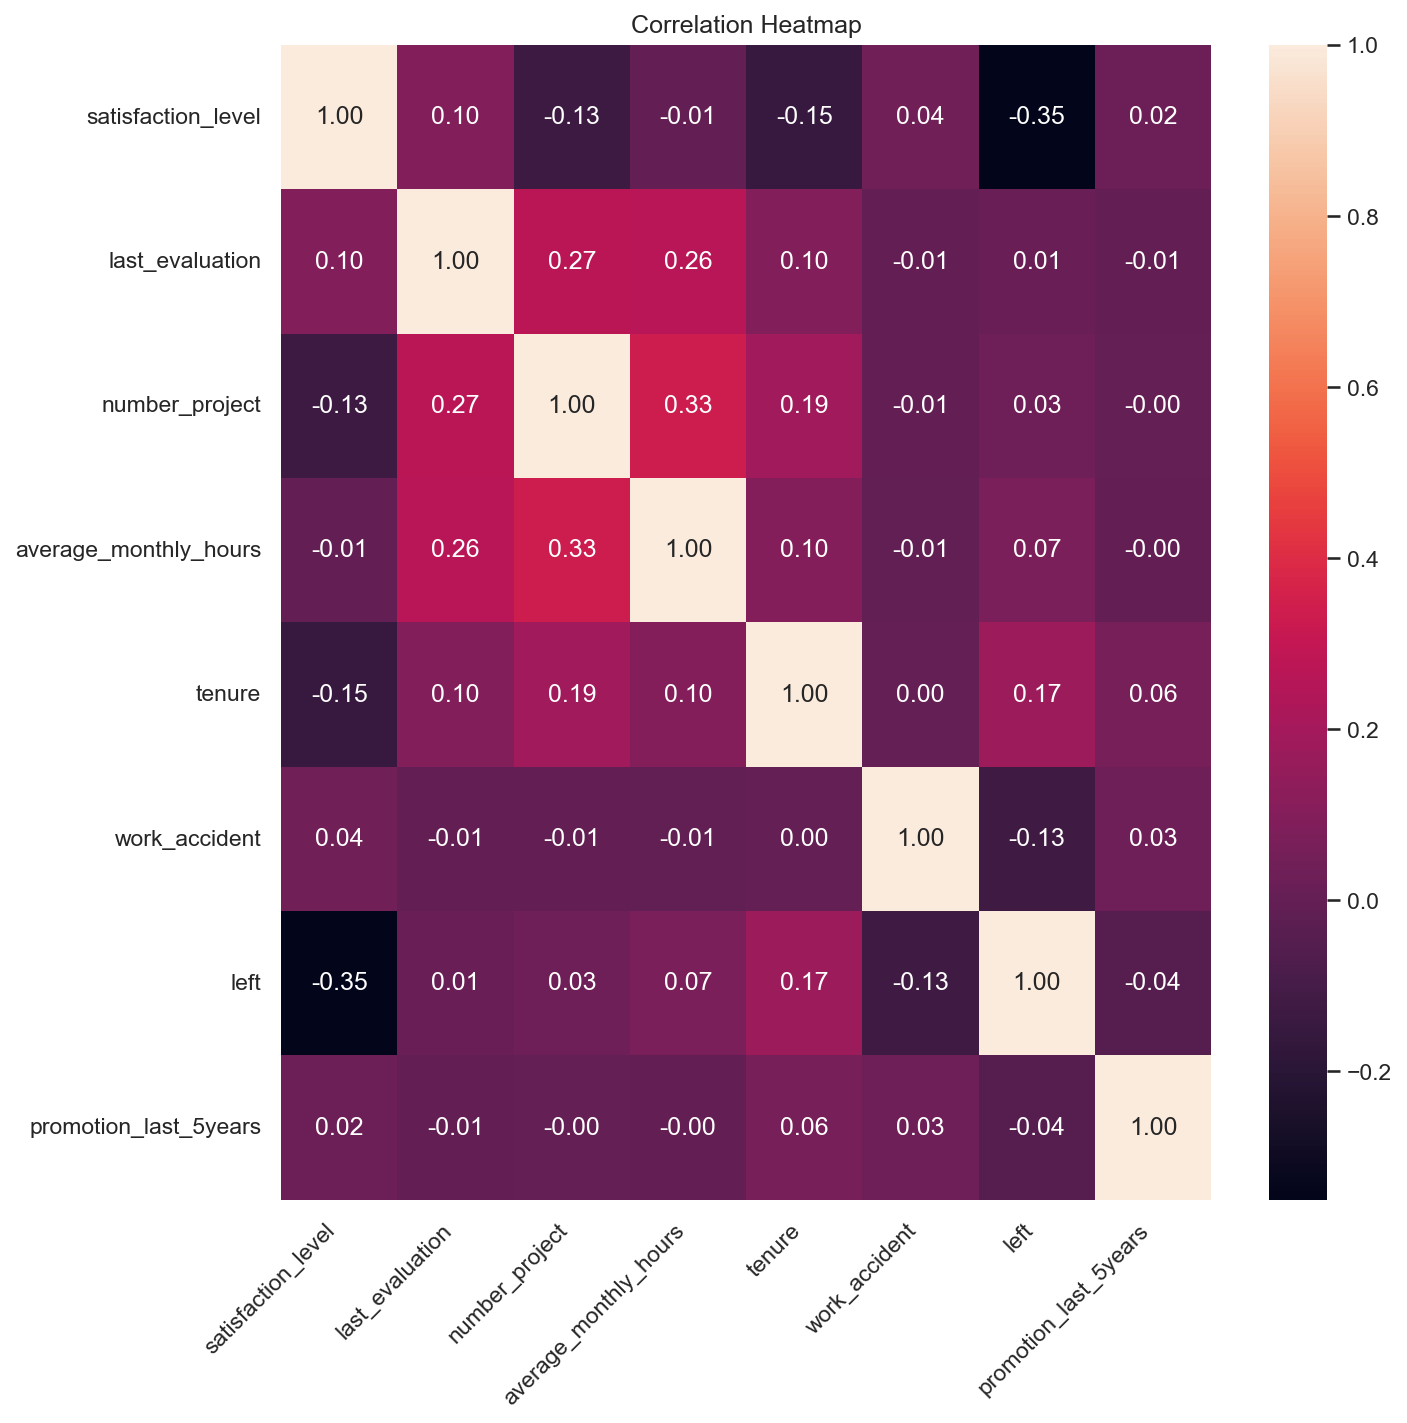

In [38]:
# Create a correlation matrix of variables without the categorical columns
correlation_matrix = data.drop(columns = ['salary', 'department']).corr()

# Create a plot
plt.figure(figsize = (10, 10), dpi = 150)
# Create a heatmap from correlation matrix values, set precision to two decimal places
sns.heatmap(correlation_matrix, annot = True, fmt = ".2f")

# Set title
plt.title('Correlation Heatmap')
# Rotate and algin x labels
plt.xticks(rotation = 45, ha = 'right')
plt.show()

- The largest correlation we see is with satisfaction level and our target variable "left". The negative correlation indicates that as satisfaction level increases, we tend to see less instances of employees who left the company.
- There is correlation present between number of projects, last evaluation score, and average monthly work hours.

<Axes: xlabel='satisfaction_level', ylabel='Count'>

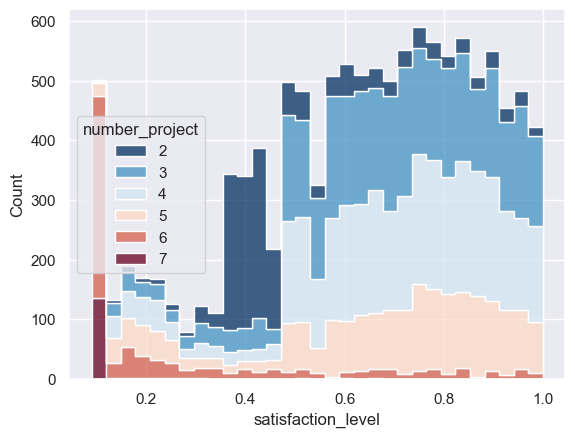

In [39]:
# this is an example of a histogram with poor readability
sns.histplot(x = data['satisfaction_level'], hue = data['number_project'], multiple = 'stack', element = 'step', palette = 'RdBu_r')

Let's perform some hypothesis testing to verify the statistical significance of these variables against the "left" variable.

## Hypothesis Testing

### Two Sample Means T-tests

First, let's verify that there is a significant difference in satisfaction level between the two groups.

Because we are comparing a continuous variable (satisfaction level) against two independent groups (left = 0 and left = 1), we can use a two-sample t-test. We are using the t-test because we are using a sample of the total population of Salifort employees, and don't know the population's standard deviation.

Two sample t-tests have the following assumptions about our data:
- Observations within each group are independent of each other.
- The distribution of satisfaction_level in each group is approximately normal.
- The variance of satisfaction_level in each group is equal.

Since each observation is a single employee who filled out a survey and we dropped duplicate rows earlier, we can confirm the independent observations assumption.

To confirm the normal distribution assumption, let's plot histograms of satisfaction_level for both groups.

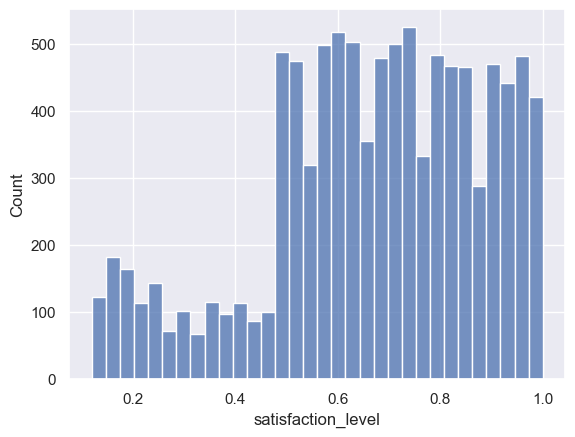

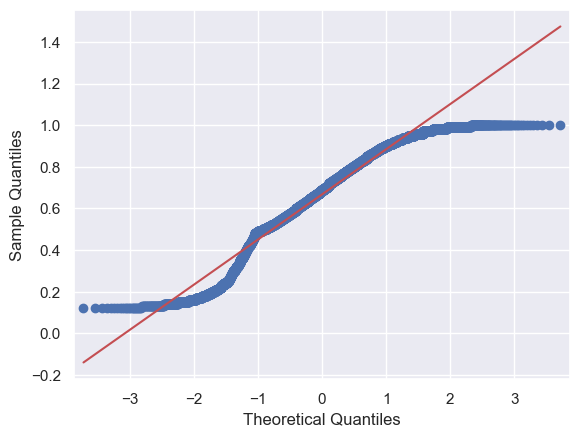

In [40]:
# Create a histogram of satisfaction level for employees who have stayed with the company
sns.histplot(data, x = data[data['left'] == 0]['satisfaction_level'])

# Create a QQ plot to evaluate normality
sm.qqplot(data[data['left'] == 0]['satisfaction_level'], line = 's');

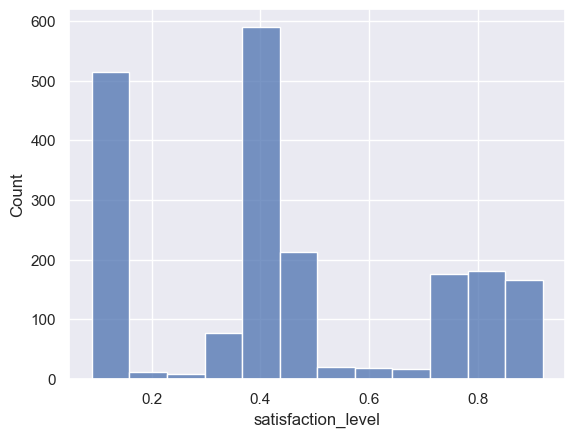

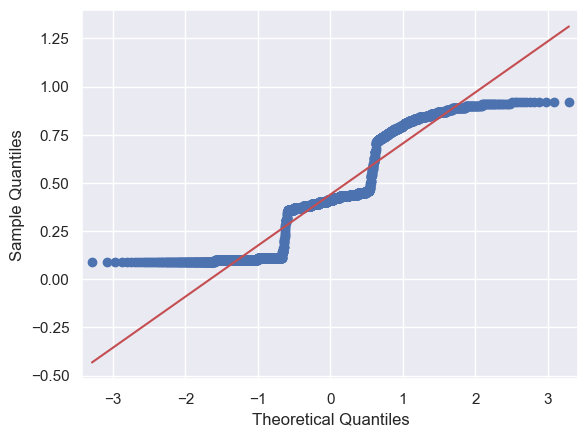

In [41]:
# Create a histogram of satisfaction level for employees who have left the company
sns.histplot(data, x = data[data['left'] == 1]['satisfaction_level'])
# Create a QQ plot to evaluate normality
sm.qqplot(data[data['left'] == 1]['satisfaction_level'], line = 's');

Well, these are certainly not normally distributed. This means that our normality assumption is not met. Does that mean we should reject the results of a t-test with this data? Not quite.

Our sample size is roughly 12,000. T-tests are robust against violations of the normality assumption when the sample size is sufficiently large. But why is that, exactly?

What our test is comparing is the *sample means* between our two groups. If we were to take many random samples from a group and calculate the means of those samples, *the distribution of those means would approach normal*. Let's demonstrate this with the satisfaction level of current Salifort employees.

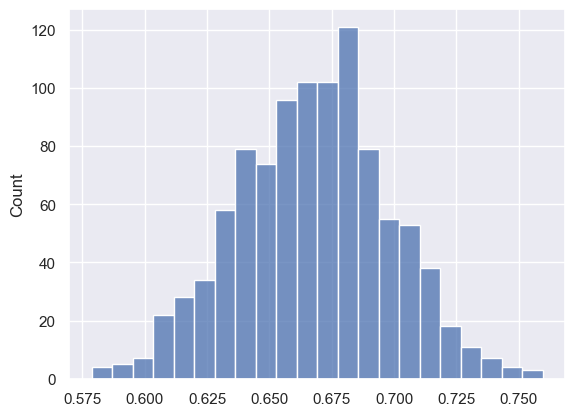

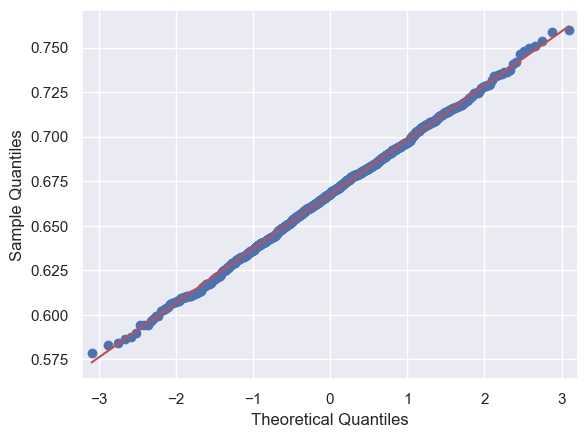

In [42]:
# Create list to store sample means in
sample_means = []
# Loop 1,000 times
for i in range(1000):
    # Get a sample from the satisfaction level of employees who have stayed with the company with replacement
    sample = data[data['left'] == 0]['satisfaction_level'].sample(n = 50, replace = True)
    # Add the average of that sample to the list
    sample_means.append(np.mean(sample))

# Plot a histogram of sample means
sns.histplot(sample_means)
# Create a QQ plot to evaluate normality
sm.qqplot(pd.Series(sample_means), line = "s");

As we can see, the distribution of sample means is normal. Our sample size is large enough to not be concerned by the normality assumption.

Next we need to assess the equal variance assumption, also known as the Homoscedasticity assumption. The variance of our two groups is assumed to be equal. We can use Levene's test here to verify.

Levene's test compares the variance of two samples. It's null hypothesis states that the variance is equal between the samples. If our p-value is greater than 0.05, our homoscedasticity assumption is met.

In [43]:
# Test if the variance of satisfaction level is equal between employees who have left the company vs those who stayed
stats.levene(data[data['left'] == 0]['satisfaction_level'], data[data['left'] == 1]['satisfaction_level'])

LeveneResult(statistic=88.15376539698202, pvalue=7.14157165224904e-21)

The result of Levene's test is a p-value of 7.1e^-21; We reject the null hypothesis and can say that the variance between our two groups is *not* equal. Our equal variance assumption is not met. That is okay! Now that we know this we will use Welch's t-test, which does not use the equal variance assumption. To do this, we will add the parameter `equal_var = False` to our function call of `ttest_ind`.

Now that the test assumptions have been assessed, we can formulate our null and alternative hypotheses.

Our hypotheses are as follows:

- $H_0$ Null Hypothesis: The mean satisfaction level between employees who left the company and current employees is the same.

- $H_a$ Alternative Hypothesis: The mean satisfaction level between employees who left the company and current employees is *not* the same.

Our significance level is 95%. If we get a p-value smaller than 0.05, we can reject the null hypothesis and say that the difference in average satisfaction level between groups is statistically significant. If that is true, then satisfaction level would be a good feature to include in modeling.

In [146]:
# Test if the difference in statisfaction level between employees who stayed vs. those who left is statistically significant
result = stats.ttest_ind(a = data[data['left'] == 0]['satisfaction_level'], b = data[data['left'] == 1]['satisfaction_level'], equal_var = False)

# Print test results
print("The test statistic (t-value) is:", result[0])
print("The p-value for our test is:", result[1])
print("The degrees of freedom in our test is: ", result.df)

# Add test results to table
test_results = pd.DataFrame(index = ['p-value', 'Statistically Significant?'])
test_results.insert(0, column = 'satisfaction_level', value = [result[1], result[1] < 0.05])
test_results

The test statistic (t-value) is: 35.88930498486623
The p-value for our test is: 1.193953844039104e-228
The degrees of freedom in our test is:  2547.316689484498


,satisfaction_level
p-value,0.0
Statistically Significant?,True


The p-value of our test is 1.2e^-228, an infinitesimally small number. We can reject the null hypothesis and state that the difference in satisfaction level between employees who left the company and those who haven't is statistically significant. We will make sure to include this variable when creating models to predict employee retention.

Let's continue our t-tests with the remaining numeric variables, and summarize our findings.

In [147]:
result = stats.ttest_ind(a = data[data['left'] == 0]['last_evaluation'], b = data[data['left'] == 1]['last_evaluation'], equal_var = False)

print("T-test for Last Evaluation Score")
print("The test statistic (t-value) is:", result[0])
print("The p-value for our test is:", result[1])
print("The degrees of freedom in our test is: ", result.df)
test_results.insert(0, column = 'last_evaluation', value = [result[1], result[1] < 0.05])

T-test for Last Evaluation Score
The test statistic (t-value) is: -1.298040887576492
The p-value for our test is: 0.1943906982070123
The degrees of freedom in our test is:  2549.55027139441


In [148]:
result = stats.ttest_ind(a = data[data['left'] == 0]['number_project'], b = data[data['left'] == 1]['number_project'], equal_var = False)

print("T-test for Number of Projects")
print("The test statistic (t-value) is:", result[0])
print("The p-value for our test is:", result[1])
print("The degrees of freedom in our test is: ", result.df)
test_results.insert(0, column = 'number_project', value = [result[1], result[1] < 0.05])

T-test for Number of Projects
The test statistic (t-value) is: -2.307798135702878
The p-value for our test is: 0.021101641546731904
The degrees of freedom in our test is:  2226.5291526046753


In [149]:
result = stats.ttest_ind(a = data[data['left'] == 0]['average_monthly_hours'], b = data[data['left'] == 1]['average_monthly_hours'], equal_var = False)

print("T-test for Average Monthly Work Hours")
print("The test statistic (t-value) is:", result[0])
print("The p-value for our test is:", result[1])
print("The degrees of freedom in our test is: ", result.df)
test_results.insert(0, column = 'average_monthly_hours', value = [result[1], result[1] < 0.05])

T-test for Average Monthly Work Hours
The test statistic (t-value) is: -6.368796832309122
The p-value for our test is: 2.2679467569333254e-10
The degrees of freedom in our test is:  2448.175778067714


In [150]:
result = stats.ttest_ind(a = data[data['left'] == 0]['tenure'], b = data[data['left'] == 1]['tenure'], equal_var = False)

print("T-test for Tenure")
print("The test statistic (t-value) is:", result[0])
print("The p-value for our test is:", result[1])
print("The degrees of freedom in our test is: ", result.df)
test_results.insert(0, column = 'tenure', value = [result[1], result[1] < 0.05])

T-test for Tenure
The test statistic (t-value) is: -24.04980075660298
The p-value for our test is: 5.787449664537035e-119
The degrees of freedom in our test is:  3742.913647541716


In [151]:
test_results = test_results[test_results.columns[::-1]]
test_results.T

,p-value,Statistically Significant?
satisfaction_level,0.0,True
last_evaluation,0.194391,False
number_project,0.021102,True
average_monthly_hours,0.0,True
tenure,0.0,True


According to our t-tests, every numeric variable except last_evaluation has a statistically significant difference in means between employees who left the company and those who have stayed. When creating our models for prediction, we will see if there is a difference in performance when we leave out last_evaluation as a feature.

#### Chi-Square Independence Tests
Now that we've tested the significance of our numeric independent variables, let's look at the categorical ones. We have two independent categorical columns; Salary and Department.

Our hypotheses for the Salary variable with regards to the Left variable are as follows:

- $H_0$ Null Hypothesis: There is no association between salary level and whether an employee has left the company. They are independent.

- $H_a$ Alternative Hypothesis: There is an association between salary level and whether an employee has left the company. They are not independent.

Since we are comparing two categorical variables, we will use the Chi-Square Test of Independence. First, let's verify the assumptions of this test:

- Each observation should be independent of other observations.
- Expected cross-tabulation cell counts should be at least 5.

Since each observation in our data is an individual employee, we meet the independence assumption. Our null hypothesis states that there is no association between the categories, and so their cross-tabulation should be roughly equal. There are no expected cross-tabulation values that would be 5 or less, so we meet this assumption as well. We can continue with our Chi-Square test.

The next step is to create a cross-tabulation of observed categorical counts.

In [50]:
# Create a cross-tabulation of salary level and whether the employee left the company
contingency_table = pd.crosstab(data['salary'], data['left'])
contingency_table

left,0,1
salary,,
high,942,48
low,4566,1174
medium,4492,769


In [152]:
# Test if there is an association between salary level and whether the employee has left the company
chi2, p_val, dof, expected = stats.chi2_contingency(contingency_table)

print("Chi-Square test for Salary Level")
print("The Chi-Square test statistic is:", chi2)
print("The p-value of our test is:", p_val)
print("The degrees of freedom in our test is:", dof)
test_results.insert(0, column = 'salary', value = [p_val, p_val < 0.05])

Chi-Square test for Salary Level
The Chi-Square test statistic is: 22.992127549276592
The p-value of our test is: 1.6266615348676462e-06
The degrees of freedom in our test is: 1


With a p-value of 8.98e^-39, we can reject the null hypothesis and say that there is an association between salary level and employee retention. Now that we've made that conclusion, how can we determine the *level* of association between categories? This is where looking at the standardized residuals of our cross-tabulation can help.

In [52]:
# Create table of standardized residuals by subtracting the expected values and dividing by the square root of expected values
standardized_residuals = (contingency_table - expected) / np.sqrt(expected)
standardized_residuals

left,0,1
salary,,
high,4.050339,-9.077281
low,-3.193109,7.156128
medium,1.578292,-3.537136


This table shows us the standard deviations for each category combination, where a value of 0 would imply independence between the categories.

Higher absolute values tell us that a combination is more associated, meaning it has more influence on the outcome.

Negative values indicate a combination has lower observed frequencies than expected if they were independent.

From our table, we can make a few conclusions:
- Employees with a high salary are much more likely to stay with the company than leave.
- Employees with a low salary are much more likely to leave the company.
- Employees with a medium salary tend to stay with the company. There are fewer employees with a medium salary that leave the company than employees who *would* leave the company *if salary and retention were not associated*.

Next, let's repeat this process for the different departments.

In [53]:
# Create a cross-tabulation of Department and our target variable
contingency_table = pd.crosstab(data['department'], data['left'])
contingency_table

left,0,1
department,,
IT,818,158
RandD,609,85
accounting,512,109
hr,488,113
management,384,52
marketing,561,112
product_mng,576,110
sales,2689,550
support,1509,312


In [153]:
chi2, p_val, dof, expected = stats.chi2_contingency(contingency_table)

print("Chi-Square test for Department")
print("The Chi-Square test statistic is:", chi2)
print("The p-value of our test is:", p_val)
print("The degrees of freedom in our test is:", dof)
test_results.insert(0, column = 'department', value = [p_val, p_val < 0.05])

Chi-Square test for Department
The Chi-Square test statistic is: 22.992127549276592
The p-value of our test is: 1.6266615348676462e-06
The degrees of freedom in our test is: 1


In [55]:
standardized_residuals = (contingency_table - expected) / np.sqrt(expected)
standardized_residuals

left,0,1
department,,
IT,0.142175,-0.318631
RandD,1.256676,-2.816357
accounting,-0.258750,0.579889
hr,-0.590022,1.322308
management,1.069513,-2.396903
marketing,-0.010733,0.024054
product_mng,0.163232,-0.365821
sales,-0.234594,0.525753
support,-0.247345,0.554330


The p-value for this test is 0.0133, and so we can reject the null hypothesis. There is an association between department and employee retention, though it is not as significant as salary level. From our table of standardized residuals, we can observe that employees in Management and R&D tend to leave the company less than if their department had no influence on their retention.

Both of our categorical independent variables have significant association with the outcome variable. We will make sure to leave them in as features for our prediction models.

We can use the same Chi-Square test to evaluate our boolean variables, "work_accident" and "promotion_last_5years". We can think of them as binary categorical variables.

In [57]:
contingency_table = pd.crosstab(data['work_accident'], data['left'])
contingency_table

left,0,1
work_accident,,
0,8255,1886
1,1745,105


In [154]:
chi2, p_val, dof, expected = stats.chi2_contingency(contingency_table)

print("Chi-Square test for Work Accidents")
print("The Chi-Square test statistic is:", chi2)
print("The p-value of our test is:", p_val)
print("The degrees of freedom in our test is:", dof)
test_results.insert(0, column = 'work_accident', value = [p_val, p_val < 0.05])

Chi-Square test for Work Accidents
The Chi-Square test statistic is: 22.992127549276592
The p-value of our test is: 1.6266615348676462e-06
The degrees of freedom in our test is: 1


In [59]:
standardized_residuals = (contingency_table - expected) / np.sqrt(expected)
standardized_residuals

left,0,1
work_accident,,
0,-2.198454,4.926991
1,5.147210,-11.535496


In [60]:
contingency_table = pd.crosstab(data['promotion_last_5years'], data['left'])
contingency_table

left,0,1
promotion_last_5years,,
0,9805,1983
1,195,8


In [155]:
chi2, p_val, dof, expected = stats.chi2_contingency(contingency_table)

print("Chi-Square test for Promotion in Last 5 Years")
print("The Chi-Square test statistic is:", chi2)
print("The p-value of our test is:", p_val)
print("The degrees of freedom in our test is:", dof)
test_results.insert(0, column = 'promotion_last_5years', value = [p_val, p_val < 0.05])

Chi-Square test for Promotion in Last 5 Years
The Chi-Square test statistic is: 22.992127549276592
The p-value of our test is: 1.6266615348676462e-06
The degrees of freedom in our test is: 1


In [62]:
standardized_residuals = (contingency_table - expected) / np.sqrt(expected)
standardized_residuals

left,0,1
promotion_last_5years,,
0,-0.259268,0.581049
1,1.975697,-4.427766


In [156]:
test_results.T

,p-value,Statistically Significant?
promotion_last_5years,0.000002,True
work_accident,0.000002,True
department,0.000002,True
salary,0.000002,True
satisfaction_level,0.0,True
last_evaluation,0.194391,False
number_project,0.021102,True
average_monthly_hours,0.0,True
tenure,0.0,True


From our hypothesis testing, we can conclude that every variable except last_evaluation has a significant difference between employees who left the company and those who stayed.

## Modeling

Now it is time to create our models to make predictions about employee retention. Our dependent variable or outcome variable is "left", which has values of 0 or 1. This is a binary classification problem. Therefore, we can use the following models to try and make predictions:

- Logistic Regression
- Naive Bayes
- Decision Tree
- Random Forest
- Gradient Boosting Machine

I will be creating a model with each method and comparing their performance. To evaluate their ability to make predictions, we'll be using the following metrics:

- Accuracy
- Precision
- Recall
- F1 Score

Accuracy will tell us the percentage of predictions that our classifier got correct.

Precision will tell us the percentage of *positive* predictions our classifier got correct. This is a little more important for the business problem we are trying to help solve. We are more interested in being able to correctly identify employees who might leave the company. Since a positive outcome in our data represents an employee who has left the company, we want our model to be really good at identifying those positive outcomes.

Recall will tell us how many actual positives were correctly identified. This is different from precision; it gives us the percentage of true positives that were correctly identified, while precision gives us the percentage of positive predictions were correct. Basically, precision shows how good the classifier is at finding any particular positive, and recall tells us how many true positives it missed.

Both precision and recall are very important for our model. We want them both to be high. The F1 score is a harmonic mean of precision and recall, essentially giving us an overall metric for the model's ability to find positive outcomes. If we can get the F1 score to be around 0.95, I would be satisfied with the model's predictive power.

Before we begin creating the models, we have one last step of EDA to do on our dataset. The categorical variables Department and Salary need to be turned into numeric representations so that our models can interpret them correctly.

Because Salary has certain levels that represent increases in salary value, we should use ordinal encoding to represent the column. This way we retain the information that a low salary is less than a medium salary, and a medium salary is less than a high salary.

In [64]:
# Create a copy of our dataset to feed into models
model_data = data.copy()

# Transform salary column into an ordinal encoding
model_data['salary'] = model_data['salary'].replace({'low': 0, 'medium': 1, 'high': 2})
model_data.head(10)

C:\Users\samti\AppData\Local\Temp\ipykernel_9052\1344027937.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  model_data['salary'] = model_data['salary'].replace({'low': 0, 'medium': 1, 'high': 2})


,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,0
1,0.80,0.86,5,262,6,0,1,0,sales,1
2,0.11,0.88,7,272,4,0,1,0,sales,1
3,0.72,0.87,5,223,5,0,1,0,sales,0
4,0.37,0.52,2,159,3,0,1,0,sales,0
5,0.41,0.50,2,153,3,0,1,0,sales,0
6,0.10,0.77,6,247,4,0,1,0,sales,0
7,0.92,0.85,5,259,5,0,1,0,sales,0
8,0.89,1.00,5,224,5,0,1,0,sales,0
9,0.42,0.53,2,142,3,0,1,0,sales,0


We will represent Department with one-hot encoding, as we don't want to imply one department has implicit value over others. This can be done with the pandas get_dummies() function.

In [65]:
# Transform department column with one-hot encoding
model_data = pd.get_dummies(model_data)
model_data.head(10)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
5,0.41,0.50,2,153,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
6,0.10,0.77,6,247,4,0,1,0,0,False,False,False,False,False,False,False,True,False,False
7,0.92,0.85,5,259,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
8,0.89,1.00,5,224,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
9,0.42,0.53,2,142,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In order to properly evaluate and test the models' performance, we need to split the data into training, verification, and test sets. We also need to separate the dependent and independent variables.

In [66]:
# Set independent variables as X
X = model_data.drop(columns = 'left')
X.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,0,0,False,False,False,False,False,False,False,True,False,False


In [67]:
# Isolate dependent/target variable 'left' as y
y = model_data['left']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: left, dtype: int64

With our X and y variables set, we can split the data into our training and testing sets.

The first split will be 75/25, giving us a training and test set. The test set will only be used for our final evaluation of the different models. We don't want to tune the models using our test set, as that may introduce overfitting when looking for optimal hyperparameters.

The next split will be 80/20, giving us the actual training and verification sets. We will use this smaller training set for the initial building of our models. Then we'll use the verification set to evaluate their performance and tune their hyperparameters. When we're satisfied with the model's performance on the verification set, we can proceed to re-train it on the whole training set and then perform our final evaluations using the test set.

In [68]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 23)

# Split the training subset into training and validation sets
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 23)

### Logistic Regression
The first model we will create is Binomial Logistic Regression. Our target variable "left" only has values of 0 or 1, meaning it is binomial. We are trying to predict an outcome with only two possible values.

Logistic Regression works by assessing the odds of each outcome based on its associated independent variables. It calculates coefficients for each independent feature that maximizes the likelihood of observing all of the outcomes seen in our training data.

#### Model Assumptions
Due to the assumptions needed for logistic regression to work properly, we may not see it perform greatly with our dataset. Those assumptions are as follows:

- No Extreme Outliers: There should not be any extreme outliers present in the X variables.

- No Multicollinearity: There should not be a linear relationship between the independent X variables.

- Logit Linearity: There should be a linear relationship between each X variable and the logit (or log-odds) of the probability that Y equals 1. What this means is that when an X variable changes there should be a linear change in the odds of our outcome being 1, or that an employee has left the company.

From our EDA, we found that the only outliers in our dataset were in the Tenure column. They were well within expectation and not extreme values, so we decided to keep them in our dataset. The first assumption is met.

To check for multicollinearity, one method is to look at the correlation between our independent variables. We saw earlier in the correlation matrix that there was some correlation between number of projects, average monthly hours, and last evaluation score. The highest correlation value was 0.33, which is not too big to be of large concern. We can also use the Variance Inflation Factor, or VIF, to check this assumption.

In [69]:
# Drop non-numeric column department and the target variable
vif_data = data.drop(columns=['department', 'left'])
# Transform salary column into ordinal encoding
vif_data['salary'] = vif_data['salary'].replace({'low': 0, 'medium': 1, 'high': 2})

# Create table to put results into
vif = pd.DataFrame()
vif['Feature'] = vif_data.columns

# Calculate VIF for each column and place in table
vif['VIF'] = [variance_inflation_factor(vif_data.values, i) for i in range(len(vif_data.columns))]
vif

C:\Users\samti\AppData\Local\Temp\ipykernel_9052\2362028393.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vif_data['salary'] = vif_data['salary'].replace({'low': 0, 'medium': 1, 'high': 2})


,Feature,VIF
0,satisfaction_level,6.781647
1,last_evaluation,18.766941
2,number_project,13.543620
3,average_monthly_hours,17.938810
4,tenure,7.128101
5,work_accident,1.181756
6,promotion_last_5years,1.029690
7,salary,1.890486


As expected, last_evaluation, number_project and average_monthly_hours have a high VIF value. Satisfaction level and tenure also have VIF values above 5, implying the presence of multicollinearity. We should consider dropping the features with high correlation or transform them in some way to improve the model's performance. For the purpose of this project, we'll compare two logistic regression models with and without this data. It is not too important that an implementation of logistic regression performs well, because we're going to be making models that are more robust to multicollinearity later.

The last assumption of Logit Linearity needs to be checked after the regression model has been made and fit to the data. We need the predicted probability of each outcome in order to calculate the log-odds. Let's go ahead and instantiate the model and fit it to our training data.

In [70]:
# Instantiate a logistic regression object and fit it to training data
logreg = LogisticRegression(max_iter = 700, random_state = 23).fit(X_tr, y_tr)

Now we can calculate the logit and plot it against each of our features to see if their relationship is linear or not.

c:\Users\samti\miniconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


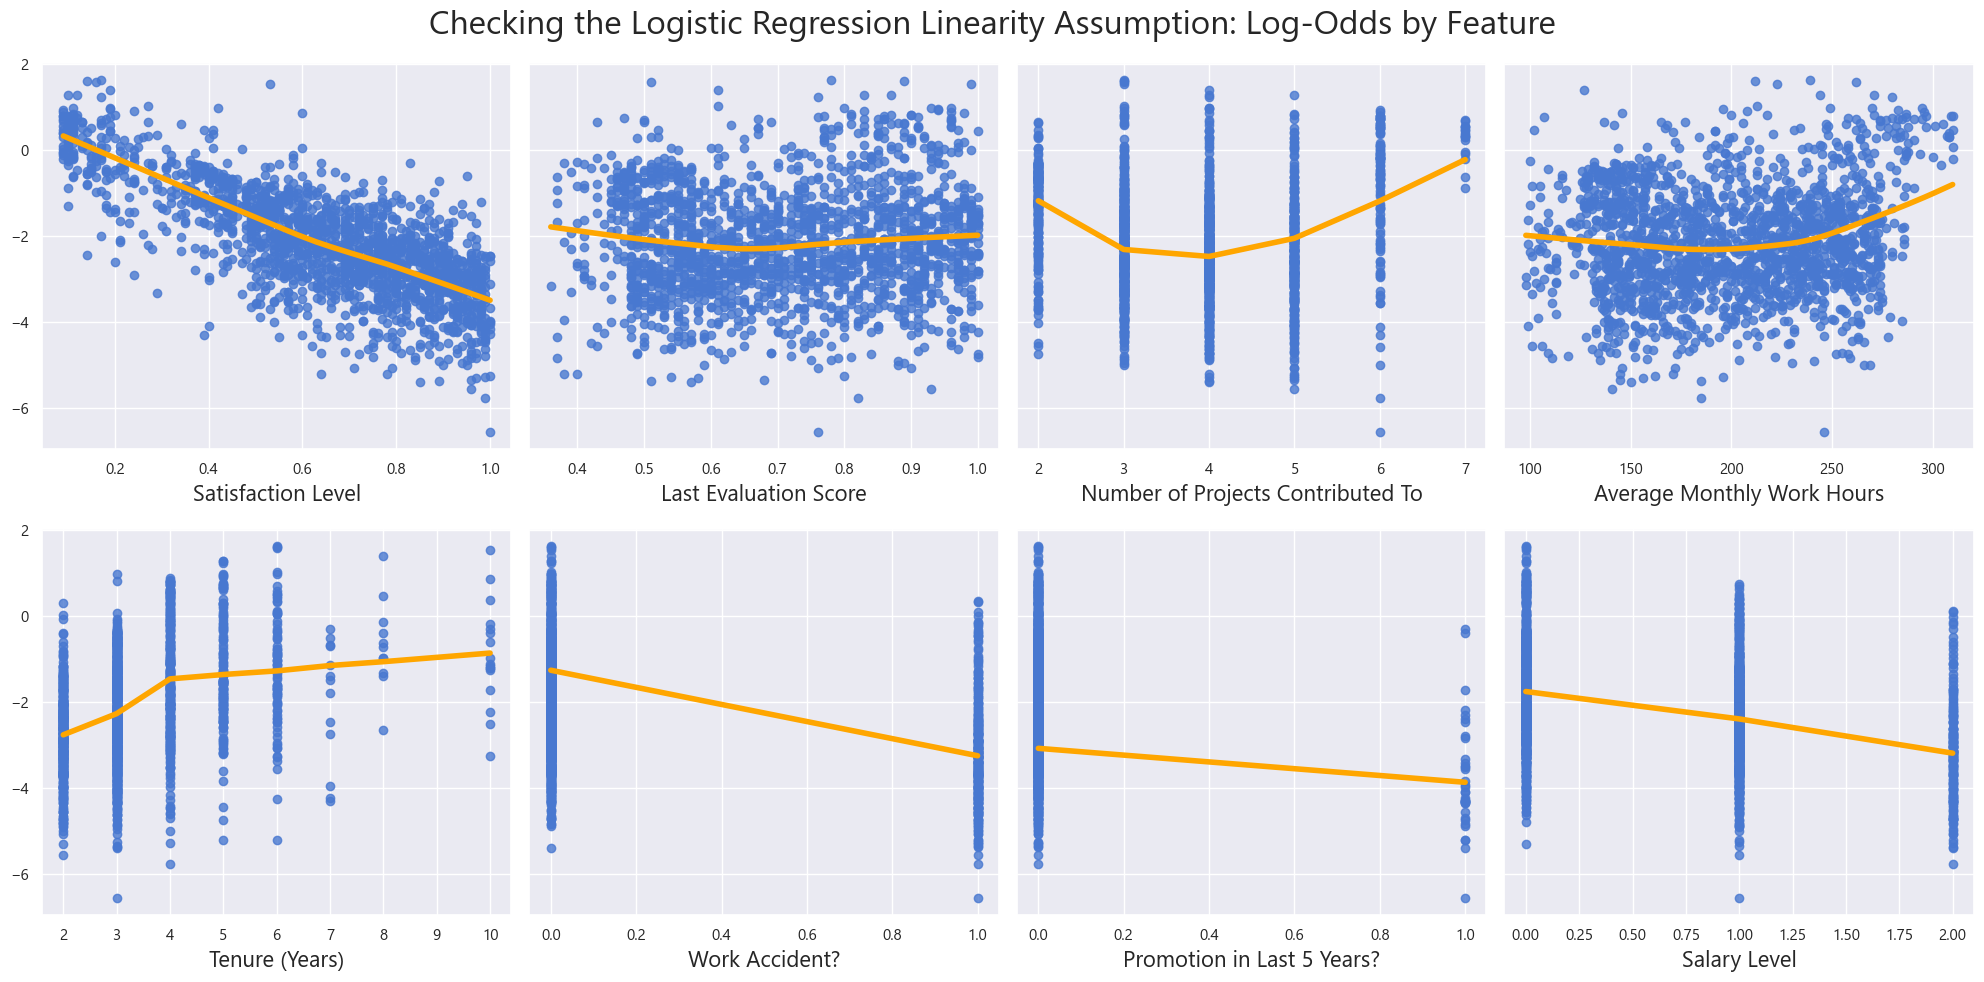

In [71]:
# Calculate the probability of each outcome and select only positive outcome probability
proba = logreg.predict_proba(X_val)[:, 1]

# Calculate the log-odds of each probability
logit = np.log((proba) / (1 - proba))

# Create a plot to show the log-odds for each feature
sns.set_style('darkgrid')
sns.set_theme(font = 'Segoe UI')
fig, axes = plt.subplots(2, 4, figsize = (20, 10), sharey = True)

# Setting lowess to True for each plot to get a non-linear line of best fit
sns.regplot(x = X_val['satisfaction_level'], y = logit, lowess = True, 
            color = '#4878d0', line_kws = {'color': '#ffa600', 'linewidth': 4}, ax = axes[0][0])
axes[0][0].set_xlabel('Satisfaction Level', fontsize = 16)

sns.regplot(x = X_val['last_evaluation'], y = logit, lowess = True, 
            color = '#4878d0', line_kws = {'color': '#ffa600', 'linewidth': 4}, ax = axes[0][1])
axes[0][1].set_xlabel('Last Evaluation Score', fontsize = 16)

sns.regplot(x = X_val['number_project'], y = logit, lowess = True, 
            color = '#4878d0', line_kws = {'color': '#ffa600', 'linewidth': 4}, ax = axes[0][2])
axes[0][2].set_xlabel('Number of Projects Contributed To', fontsize = 16)

sns.regplot(x = X_val['average_monthly_hours'], y = logit, lowess = True, 
            color = '#4878d0', line_kws = {'color': '#ffa600', 'linewidth': 4}, ax = axes[0][3])
axes[0][3].set_xlabel('Average Monthly Work Hours', fontsize = 16)

sns.regplot(x = X_val['tenure'], y = logit, lowess = True, 
            color = '#4878d0', line_kws = {'color': '#ffa600', 'linewidth': 4}, ax = axes[1][0])
axes[1][0].set_xlabel('Tenure (Years)', fontsize = 16)

sns.regplot(x = X_val['work_accident'], y = logit, lowess = True, 
            color = '#4878d0', line_kws = {'color': '#ffa600', 'linewidth': 4}, ax = axes[1][1])
axes[1][1].set_xlabel('Work Accident?', fontsize = 16)

sns.regplot(x = X_val['promotion_last_5years'], y = logit, lowess = True, 
            color = '#4878d0', line_kws = {'color': '#ffa600', 'linewidth': 4}, ax = axes[1][2])
axes[1][2].set_xlabel('Promotion in Last 5 Years?', fontsize = 16)

sns.regplot(x = X_val['salary'], y = logit, lowess = True, 
            color = '#4878d0', line_kws = {'color': '#ffa600', 'linewidth': 4}, ax = axes[1][3])
axes[1][3].set_xlabel('Salary Level', fontsize = 16)

fig.suptitle('Checking the Logistic Regression Linearity Assumption: Log-Odds by Feature', fontsize = 24)
plt.tight_layout()
plt.show()

As seen by the yellow lines of best fit, not every feature has a linear relationship to the logit. Number of projects, average monthly hours, and tenure have obviously non-linear lines. Last evaluation score also has a visible bend around the 0.6 mark.

Boolean features like work_accident, promotion_last_5years, and our one-hot encoded departments will always show a linear best-fit line due to only having two average points to make the line with.

This graph confirms we should probably drop or transform last_evaluation_score, number_projects, and average_monthly_hours. Let's see if a logistic regression model without those features performs better.

#### Classifier Evaluation Functions

In [72]:
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Returns a plot of confusion matrix for predictions on y data.
    ''' 
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
  
    disp.plot()
    plt.show()

def evaluate_classifier(modelname, model, x_data, y_data):
    '''
    Accepts model name, model object, X data, and y data.
    Returns classifier evaluation metrics and shows a confusion matrix of the results.
    '''
    model_preds = model.predict(x_data)

    # Print evaluation metrics
    print("Evaluation of", modelname, 'Classifier')
    print("Accuracy:\t", "%.4f" % (accuracy_score(y_data, model_preds) * 100), '%')
    print("Precision:\t", "%.4f" % (precision_score(y_data, model_preds) * 100), '%')
    print("Recall:\t\t", "%.4f" % (recall_score(y_data, model_preds) * 100), '%')
    print("F1 Score:\t", "%.4f" % f1_score(y_data, model_preds))

    # Plot confusion matrix
    sns.set_style("white")
    print("\nConfusion Matrix for", modelname, 'Classifier')
    conf_matrix_plot(model, x_data, y_data)

#### Model Evaluation

##### Logistic Regressor with Invalidated Assumptions

Evaluation of Logistic Regression Classifier
Accuracy:	 84.7693 %
Precision:	 46.2963 %
Recall:		 18.7970 %
F1 Score:	 0.2674

Confusion Matrix for Logistic Regression Classifier


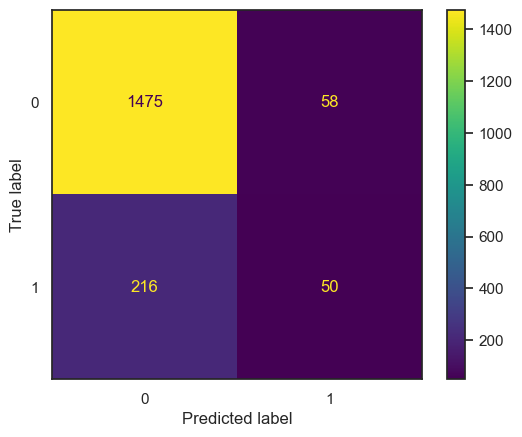

In [73]:
evaluate_classifier('Logistic Regression', logreg, X_val, y_val)

The confusion matrix of our classifier shows the predicted labels and actual labels of the data it saw.
- The top left shows employees who stayed with the company, that our model correctly predicted would stay with the company.
- The bottom left shows employees who stayed with the company, that our model incorrectly predicted would leave the company.
- The top right shows employees who left the company, that our model incorrectly predicted would stay with the company.
- The bottom right shows employees who left the company, that our model correctly predicted would leave the company.

We want to see high values in the top left and bottom right, and low values in the top right and bottom left.

Unfortunately, it appears our model has a tendency to incorrectly predict true positives. This will be reflected in a lowered precision and recall score.

Let's see how a model without the highly correlated independent variables performs.

In [74]:
# Create a table to hold model evaluation metrics
model_evaluation = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall', 'F1 Score'])
model_evaluation['Invalid Logistic Regression'] = [84.77, 46.30, 18.80, 0.27]

##### Logistic Regressor with Validated Assumptions

In [75]:
logreg_X_val = X_val.drop(columns = ['last_evaluation', 'number_project', 'average_monthly_hours'])
logreg_valid = LogisticRegression(max_iter = 700, random_state = 23).fit(logreg_X_val, y_val)

Evaluation of Valid Logistic Regression Classifier
Accuracy:	 85.7143 %
Precision:	 54.8387 %
Recall:		 19.1729 %
F1 Score:	 0.2841

Confusion Matrix for Valid Logistic Regression Classifier


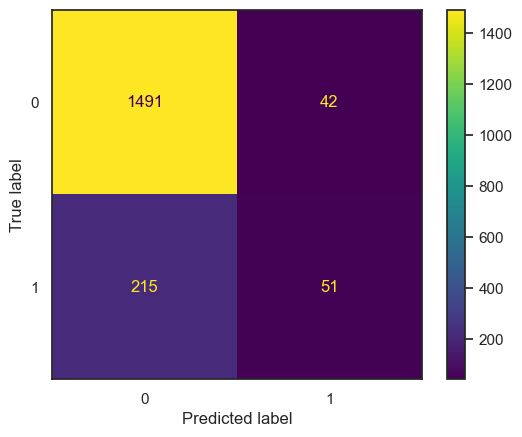

In [76]:
evaluate_classifier('Valid Logistic Regression', logreg_valid, logreg_X_val, y_val)

In [77]:
model_evaluation['Valid Logistic Regression'] = [85.71, 54.84, 19.17, 0.28]
model_evaluation

,Invalid Logistic Regression,Valid Logistic Regression
Accuracy,84.77,85.71
Precision,46.30,54.84
Recall,18.80,19.17
F1 Score,0.27,0.28


As seen in the evaluation metrics, dropping the invalid data improved our model's performance. The precision was improved the most, by over 8%. Still, this model does not do a great job at what we want; predicting positive outcomes. The purpose of this project is to create a model that can predict if an employee will leave the company. A precision value of 54.8% means that for any given employee that will in fact leave, our model only has a ~55% chance of getting its prediction right. More than that, a recall value of 19% means that only 19% of total employees who will leave would be correctly identified! We can surely do better than that.

Before we move on to more robust models, let's look at the coefficients produced by our logistic regressor. These values tell us how much the likelihood of the outcome being positive increases or decreases with changes in our independent variables.

In [78]:
logreg_coefs = pd.DataFrame(index = logreg_X_val.columns)
logreg_coefs['Coefficients'] = logreg_valid.coef_[0]
logreg_coefs

,Coefficients
satisfaction_level,-3.523222
tenure,0.295120
work_accident,-1.234027
promotion_last_5years,-0.246509
salary,-0.594099
department_IT,0.285864
department_RandD,-0.865267
department_accounting,0.356814
department_hr,0.300728
department_management,-0.540217


The intepretations of these values are not concrete, as they are based on the conclusions of the logistic regression model which we saw did not perform well.

This model says that:
- Satisfaction level is on a scale from 0 to 1, and the coefficients show the change from a 1-unit increase. This means the coefficient for satisfaction level corresponds to a perfect satisfaction level of 1. If an employee has a perfect satisfaction level, there is a 3.5% decrease in the probability they will leave the company.
- For each year an employee works at the company, there is a 0.3% increase in the probability they will leave the company.
- If an employee has a work-related accident, there is a 1.2% decrease in the probability that they will leave the company.
- If an employee has had a promotion in the last 5 years, there is a 0.25% decrease in the probability that they will leave the company.
- For each tier of salary (low, medium high) there is a 0.59% decrease in the probability that they will leave the company.
- Each department has differing probabilities of employees leaving. An employee in the R&D department has a 0.87% decrease in the probability of them leaving. An employee in the marketing department has a 0.38% increase in that probability.

### Naive Bayes

The next model we will create is a Naive Bayes Classifier.

This model uses Bayes' Theorem to calculate the posterior probability of an outcome given the observed data. Essentially, it calculates the probability of seeing a given outcome based on the first input given, and then updates its assumptions with new evidence. We repeat that process for each observation until we have a final calculation of probability.

There are two main assumptions for a Naive Bayes Classifier:

- Conditional Independence: Each independent variable is assumed to be conditionally independent from each other, such that a change in one variable does not create change in another variable.
- Equal Predictive Power: This is the assumption that gives this classifier its "Naive" name. The model assumes that every independent variable has the same predictive power, and contribute equally to the outcome.

We've seen in previous analysis that neither of these assumptions are necessarily met by our data. However, a Naive Bayes model can still perform well even with violations of its assumptions.

Implementations of Naive Bayes change depending on the data we want to analyze. GaussianNB assumes a normal (or Gaussian) distribution of the likelihood of our data, and is used for continuous variables. BernoulliNB is used for boolean variables, and MultinomialNB is used for discrete variables.

In our data, we have a mix of continuous, discrete, and boolean variables. So how can we implement a single Naive Bayes classifier for all of our data? We have two options:

- Just throw all our data into a GaussianNB classifier and call it good enough. Naive Bayes classifiers are surprisingly robust against its assumptions, and we'll be making better models soon anyways.
- Fit three different Naive Bayes classifiers on the different data types, and combine their results.

I'm not quite satisfied with the first option, and want to learn how to implement the second option. So here we go!

##### Combined Naive Bayes
First, we'll need to split up our data into the different data types.

In [79]:
X_tr_continuous = X_tr[['satisfaction_level', 'last_evaluation', 'average_monthly_hours']].copy()
X_tr_continuous.head()

,satisfaction_level,last_evaluation,average_monthly_hours
8988,0.96,0.93,238
11846,0.76,0.62,230
5382,0.19,0.72,243
9681,0.31,0.70,182
3404,0.74,0.91,264


In [80]:
X_tr_discrete = X_tr[['number_project', 'tenure', 'salary']]
X_tr_discrete.head()

,number_project,tenure,salary
8988,3,2,0
11846,5,3,0
5382,6,6,0
9681,4,3,1
3404,2,3,0


In [81]:
X_tr_boolean = X_tr.drop(columns = ['satisfaction_level', 'last_evaluation', 'average_monthly_hours', 'number_project', 'tenure', 'salary'])
X_tr_boolean.head()

,work_accident,promotion_last_5years,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
8988,0,0,False,False,False,False,False,False,False,False,False,True
11846,1,0,False,False,False,False,False,True,False,False,False,False
5382,1,0,False,False,False,False,False,False,False,False,False,True
9681,0,0,True,False,False,False,False,False,False,False,False,False
3404,0,0,False,False,False,False,False,False,False,False,True,False


Now, we create our different implementations of Naive Bayes classifiers and fit them to our training data.

In [82]:
gnb = naive_bayes.GaussianNB().fit(X_tr_continuous, y_tr)
mnb = naive_bayes.MultinomialNB().fit(X_tr_discrete, y_tr)
bnb = naive_bayes.BernoulliNB().fit(X_tr_boolean, y_tr)

Next, we get the predicted probabilities for each outcome from each classifier.

In [83]:
gnb_proba = gnb.predict_proba(X_tr_continuous)
mnb_proba = mnb.predict_proba(X_tr_discrete)
bnb_proba = bnb.predict_proba(X_tr_boolean)

Then we combine those probabilities by multiplying them.

In [84]:
combined_proba = gnb_proba * mnb_proba * bnb_proba
combined_proba

array([[6.07229362e-01, 2.36391970e-03],
       [7.18105530e-01, 6.80149572e-04],
       [3.55631692e-01, 8.22804586e-03],
       ...,
       [6.53751701e-01, 1.55372131e-03],
       [5.15916642e-01, 7.70894569e-03],
       [6.87678232e-01, 1.25771843e-03]])

We then divide those combined probabilities by the class prior, or the ratio of employees who stayed and who left.

In [85]:
combined_proba = combined_proba / gnb.class_prior_
combined_proba

array([[0.72964891, 0.01408951],
       [0.8628781 , 0.00405385],
       [0.42732828, 0.04904106],
       ...,
       [0.78555032, 0.00926054],
       [0.61992723, 0.0459471 ],
       [0.82631655, 0.00749629]])

Finally, to get the predictions from our combined classifier results, we calculate which probability in each row is higher.

In [86]:
combined_predictions = np.argmax(combined_proba, axis = 1)
combined_predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Evaluation of Combined Naive Bayes Classifier
Accuracy:	 84.9458 %
Precision:	 96.9697 %
Recall:		 10.6048 %
F1 Score:	 0.1912


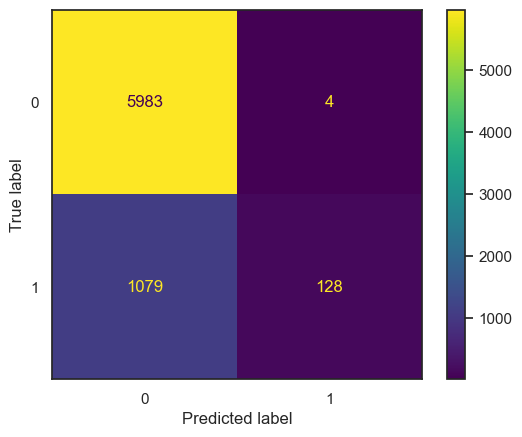

In [87]:
print("Evaluation of Combined Naive Bayes Classifier")
print("Accuracy:\t", "%.4f" % (accuracy_score(y_tr, combined_predictions) * 100), '%')
print("Precision:\t", "%.4f" % (precision_score(y_tr, combined_predictions) * 100), '%')
print("Recall:\t\t", "%.4f" % (recall_score(y_tr, combined_predictions) * 100), '%')
print("F1 Score:\t", "%.4f" % f1_score(y_tr, combined_predictions))

cm = confusion_matrix(y_tr, combined_predictions, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=[0, 1])

disp.plot()
plt.show()

Ouch. This combined classifier did not perform too well. Remember that the purpose of this project is to create a model that's good at identifying positive outcomes, or employees who would leave Salifort Motors. We want both our precision and recall, and therefore the F1 score, to be high. This model does have very good precision at almost 97%, which means when it does predict a positive label it's correct about 97% of the time. However, it appears that precision comes with a steep decline in recall. Our model incorrectly classified 1,079 employees who left the company, leading to a recall of only 10.6%. Not great!

The problem with this approach is that by splitting up our data and training seperate models, we miss out on finding connections between those splits. There's a lot of information that could inform our model that is removed. So what happens if we go back to our first option and falsely assume all of our data has Guassian distributed likelihoods?

##### Gaussian Only Naive Bayes

Evaluation of Invalid Gaussian NB Classifier
Accuracy:	 80.8869 %
Precision:	 45.6432 %
Recall:		 72.9080 %
F1 Score:	 0.5614

Confusion Matrix for Invalid Gaussian NB Classifier


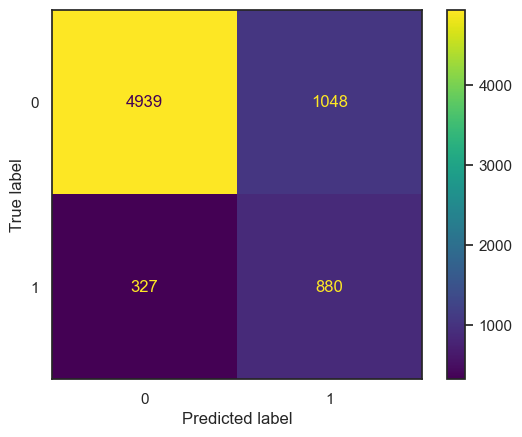

In [88]:
invalid_gnb = naive_bayes.GaussianNB().fit(X_tr, y_tr)
evaluate_classifier('Invalid Gaussian NB', invalid_gnb, X_tr, y_tr)

In [89]:
model_evaluation['Combined Naive Bayes'] = [84.95, 96.97, 10.60, 0.19]
model_evaluation['Invalid Gaussian Naive Bayes'] = [80.89, 45.64, 72.91, 0.56]
model_evaluation

,Invalid Logistic Regression,Valid Logistic Regression,Combined Naive Bayes,Invalid Gaussian Naive Bayes
Accuracy,84.77,85.71,84.95,80.89
Precision,46.30,54.84,96.97,45.64
Recall,18.80,19.17,10.60,72.91
F1 Score,0.27,0.28,0.19,0.56


Funnily enough, for the purposes of this project, this version performs better than the "proper" method used before. We lose a ton of precision and some accuracy, but the recall is much better and we get a higher F1 score. Instead of having a ton of false negatives, we have a ton of false positives. Still not great, but when we violated assumptions about the data we made improvements. Even though most of our data doesn't have a normal likelihood distribution, the information about their correlations gave us more predictive power than what was lost by using an invalid implementation.

The combined Naive Bayes classifier performed overall worse than the logistic regressor. Our invalid Gaussian Naive Bayes model had slightly worse accuracy and precision, but far better recall and F1 score.

We can do better. What if we used models that require less strict assumptions about our diverse data?

### Decision Tree

The next model we will create and assess is a Decision Tree.

A Decision Tree works by creating a tree of decision nodes, where a single feature is considered and the outcome is split in a way that maximizes the node's predictive power. Each node wants to produce two child nodes that minimize the *impurity*, or mix of outcomes. A perfect split would result in two child nodes that only contain one outcome.

Decision Trees are great classifiers because they don't require assumptions about the data's distributions, can work with all types of data, and give us a transparent look into how its decisions are made. However, they require more computation than simpler models, and are prone to overfitting. By default, a decision tree will grow until all leaf nodes (nodes where a final prediction is made) are completely pure. To avoid that overfitting, we'll be tuning the tree using GridSearchCV to find an optimal combination of hyperparameters.

Let's first create a non-tuned decision tree to compare to our optimal version.

In [90]:
dt = DecisionTreeClassifier(random_state = 23)

dt.fit(X_tr, y_tr)

DecisionTreeClassifier(random_state=23)

Evaluation of Decision Tree Classifier
Accuracy:	 95.8310 %
Precision:	 83.9858 %
Recall:		 88.7218 %
F1 Score:	 0.8629

Confusion Matrix for Decision Tree Classifier


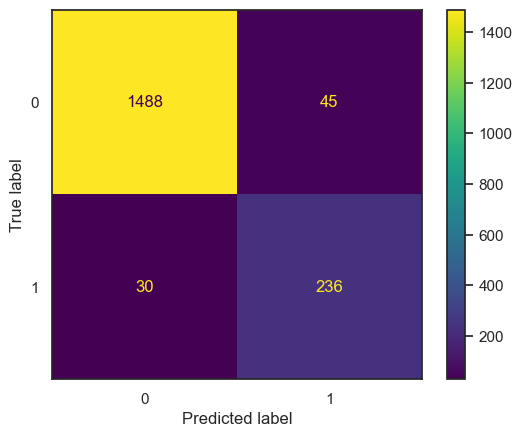

In [91]:
evaluate_classifier('Decision Tree', dt, X_val, y_val)

In [92]:
model_evaluation['Decision Tree'] = [95.83, 83.99, 88.72, 0.86]
model_evaluation

,Invalid Logistic Regression,Valid Logistic Regression,Combined Naive Bayes,Invalid Gaussian Naive Bayes,Decision Tree
Accuracy,84.77,85.71,84.95,80.89,95.83
Precision,46.30,54.84,96.97,45.64,83.99
Recall,18.80,19.17,10.60,72.91,88.72
F1 Score,0.27,0.28,0.19,0.56,0.86


This model is already performing far better than our previous classifiers. One of the cool things about decision trees is the ability to visualize the tree and see the different nodes, and how they're making decisions.

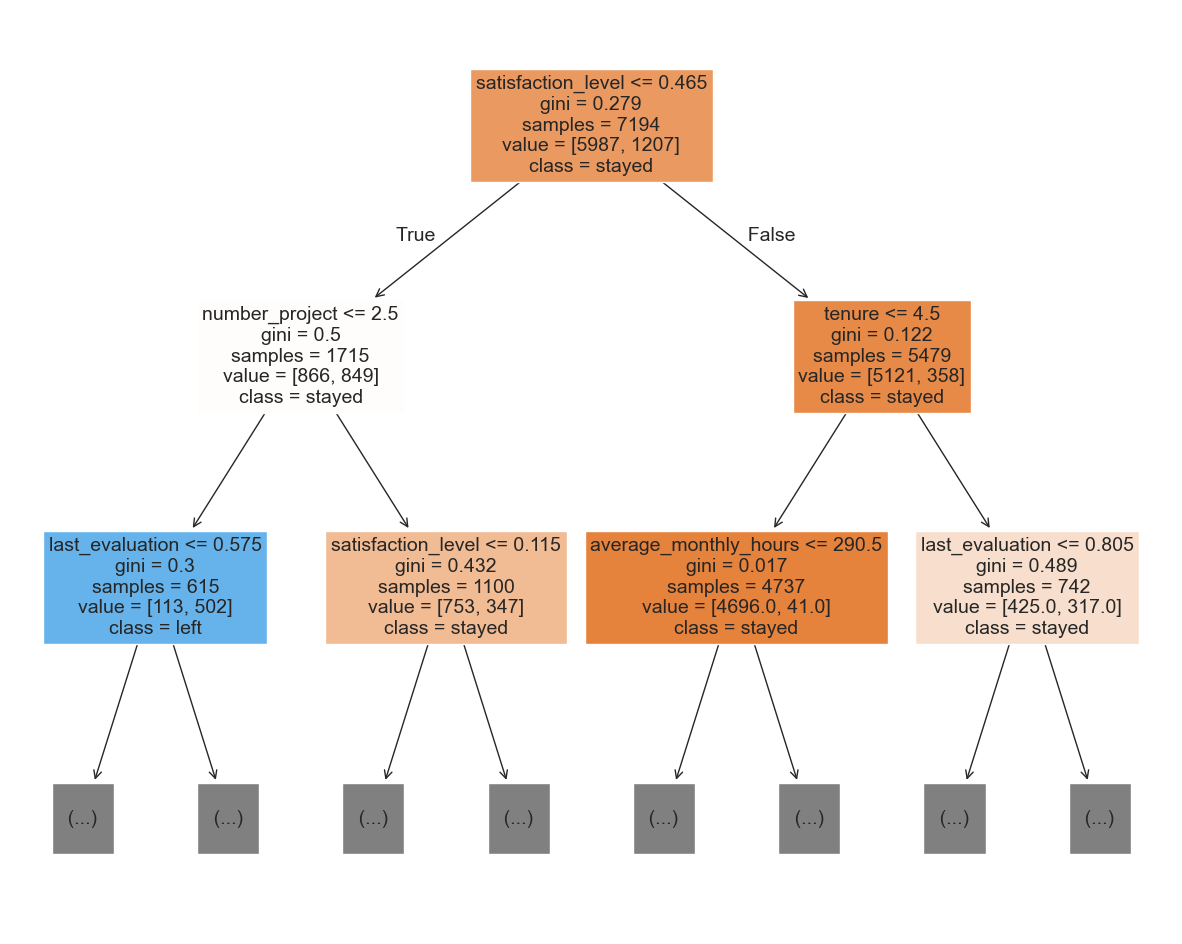

In [93]:
plt.figure(figsize=(15,12))
plot_tree(dt, max_depth=2, fontsize=14, feature_names=X.columns.to_list(), 
          class_names=['stayed', 'left'], filled=True);
plt.show()

The first, or *root* node, represents the decision split with the greatest predictive power. Our tree plot shows that a split in satisfaction level at 0.465 is the most powerful at finding differences between employees who stay at or leave the company. "gini" represents the *Gini Impurity* value, a measure of the node's outcome balance. The tree is trying to minimize that value. "samples" shows how many rows of data apply to that node's decision, and "value" shows us how many of each outcome are present at the node. "class" displays the majority of outcomes in the node, and what it would predict the outcome to be if it were a leaf node.

Let's take a look at the shape of our tree by accessing the `tree_` attribute.

In [94]:
print("Node Count:", dt.tree_.node_count)
print("Max Tree Depth:", dt.tree_.max_depth)

Node Count: 485
Max Tree Depth: 21


This decision tree has a total of 485 decision nodes, and a max depth of 21. Remember that by default, a decision tree will grow until all leaf nodes are completely pure. However, letting a tree grow this way is almost guarunteed to overfit the training data. We want to limit the growth of the tree so that its decisions are more widely applicable to new data.

To find optimal limits for the tree's growth, we can use the GridSearchCV function to systematically create and compare trees with all combinations of parameters we enter.

To use GridSearchCV, we must first specify the hyperparameters to compare and the scoring methods we want to evaluate the models by. `max_depth` specifies how deep the decision tree is allowed to grow, and `min_samples_leaf` specifies how many samples should be in a node to consider it a leaf node and ready to be a final predictor.

In [95]:
dt_para = {
    'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40,50],
    'min_samples_leaf': [2,3,4,5,6,7,8,9, 10, 15, 20, 50]
}
scoring = ['accuracy', 'precision', 'recall', 'f1']

Then we instantiate the model object to be analyzed.

In [96]:
dt_tune = DecisionTreeClassifier(random_state = 23)

Now we create a GridSearchCV object and fit it to our training data. Running this cell can take a long time, since we are creating and comparing models with every possible permutation of hyperparameter values.

In [97]:
%%time

dt_tuned = GridSearchCV(
    dt_tune,
    dt_para,
    scoring = scoring,
    cv = 5,
    refit = 'f1'
)

# dt_tuned.fit(X_tr, y_tr)

CPU times: total: 0 ns
Wall time: 0 ns


To get the best performing hyperparemeter values, we look at the `best_estimator_` attribute of our GridSearchCV object.

In [98]:
# dt_tuned.best_estimator_

Looks like the best values for our decision tree is a `max_depth` of 8 and a `min_samples_leaf` of 2. Let's now create a model with those hyperparameter values.

In [99]:
dt_optimal = DecisionTreeClassifier(random_state = 23, max_depth = 8, min_samples_leaf = 2)
dt_optimal.fit(X_tr, y_tr)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=2, random_state=23)

Evaluation of Optimized Decision Tree Classifier
Accuracy:	 97.8321 %
Precision:	 94.5098 %
Recall:		 90.6015 %
F1 Score:	 0.9251

Confusion Matrix for Optimized Decision Tree Classifier


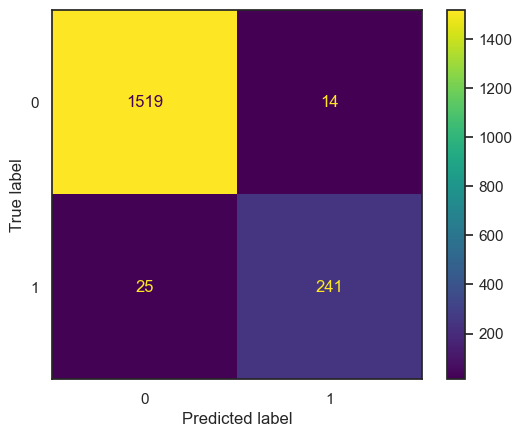

In [100]:
evaluate_classifier('Optimized Decision Tree', dt_optimal, X_val, y_val)

In [101]:
model_evaluation['Optimized Decision Tree'] = [97.83, 94.51, 90.60, 0.93]
model_evaluation.T

,Accuracy,Precision,Recall,F1 Score
Invalid Logistic Regression,84.77,46.30,18.80,0.27
Valid Logistic Regression,85.71,54.84,19.17,0.28
Combined Naive Bayes,84.95,96.97,10.60,0.19
Invalid Gaussian Naive Bayes,80.89,45.64,72.91,0.56
Decision Tree,95.83,83.99,88.72,0.86
Optimized Decision Tree,97.83,94.51,90.60,0.93


Now that's looking pretty good! Our optimized decision tree performed very well. It was able to correctly predict outcomes 97.8% of the timee. It also correctly predicted an employee would leave the company 94.5% of the time. In total, 90.6% of employees who left the company were correctly identified. With an F1 score of 0.93, we're making big improvements.

Let's take a quick look at the shape of this optimal tree.

In [102]:
print("Node Count:", dt_optimal.tree_.node_count)
print("Max Tree Depth:", dt_optimal.tree_.max_depth)

Node Count: 119
Max Tree Depth: 8


Our maximum tree depth is 8 nodes, since we set that as a hyperparemeter. Now the total number of decision nodes has been reduced to 119.

This model performed well, but what if we could push it even further? Next, we'll explore a method called *bagging* that uses an ensemble of decision trees to make predictions. Bagging refers to Bootstrap Aggregating.

### Random Forest
A Random Forest model consists of an ensemble of decision trees that only have access to a subset of our data's samples and features. The observations given to each decision tree, or base learner, are sampled with replacement from the full training set. This process is known as Bootstrapping. Their prediction probabilities are then aggregated into a final prediction.

Utilizing ensemble learning and bagging reduces the variance in our final predictions. It can also be surprisingly fast, as the base learners can be built in parallel across different CPU cores.

The different hyperparameters for a Random Forest include:

- `n_estimators`: The number of base learners created for the ensemble.
- `max_depth`: The maximum depth of each base learner.
- `min_samples_leaf`: The minimum number of samples for a node to be considered a leaf node.
- `min_samples_split`: The minimum number of samples required to split a node.
- `max_features`: The maximum number of features that can be given to each base learner.
- `max_samples`: The amount of training data to be bootstrapped and given to each base learner.

By default, a scikit-learn random forest has:
- 100 base learners
- An unlimited max depth for each base learner
- `min_samples_leaf` of 1 sample
- `min_samples_split` of 2 samples
- A `max_features` value equal to the square root of total number of features
- A `max_samples` value equal to the amount of total samples.

Let's see how a default random forest performs, then use GridSearchCV to find more optimal values for the hyperparameters.

In [103]:
rf = RandomForestClassifier(random_state = 23)
rf.fit(X_tr, y_tr)

RandomForestClassifier(random_state=23)

Evaluation of Random Forest Classifier
Accuracy:	 98.2212 %
Precision:	 98.7500 %
Recall:		 89.0977 %
F1 Score:	 0.9368

Confusion Matrix for Random Forest Classifier


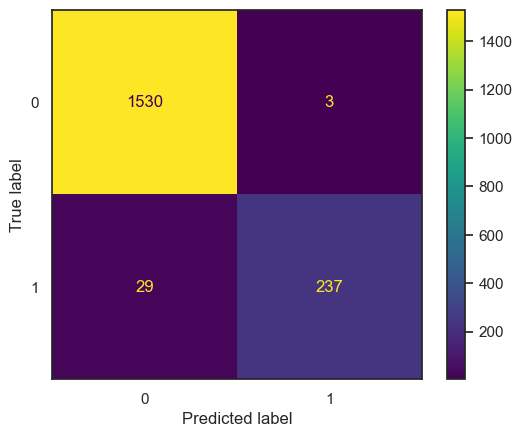

In [104]:
evaluate_classifier('Random Forest', rf, X_val, y_val)

In [105]:
model_evaluation['Random Forest'] = [98.22, 98.75, 89.10, 0.94]
model_evaluation.T

,Accuracy,Precision,Recall,F1 Score
Invalid Logistic Regression,84.77,46.30,18.80,0.27
Valid Logistic Regression,85.71,54.84,19.17,0.28
Combined Naive Bayes,84.95,96.97,10.60,0.19
Invalid Gaussian Naive Bayes,80.89,45.64,72.91,0.56
Decision Tree,95.83,83.99,88.72,0.86
Optimized Decision Tree,97.83,94.51,90.60,0.93
Random Forest,98.22,98.75,89.10,0.94


The default random forest performed ever so slightly better than our single decision tree. However, it missed a few more true positives, and so the recall is down by 1.5%. Let's tune it so we see better results.

In [106]:
rf_para = {
    'n_estimators' : [100, 200, 300, 500], 
    'max_depth' : [5, 8, 10, 25, 50],
    'min_samples_leaf' : [0.5, 1, 2], 
    'min_samples_split' : [0.001, 0.01],
    'max_features' : ["sqrt", 2, 4, 6],
    'max_samples' : [.3, .5, .7]
}

In [107]:
rf_tune = RandomForestClassifier(random_state = 23)

rf_tuned = GridSearchCV(
    rf_tune,
    rf_para,
    scoring = scoring,
    cv = 5,
    refit = "f1"
)

In [108]:
%%time

# rf_tuned.fit(X_tr, y_tr)

CPU times: total: 0 ns
Wall time: 0 ns


In [109]:
rf_optimal = RandomForestClassifier(
    n_estimators = 500,
    max_depth = 25,
    max_features = 'sqrt',
    max_samples = 0.9,
    min_samples_leaf = 1,
    min_samples_split = 0.001,
    random_state = 23
)
rf_optimal.fit(X_tr, y_tr)

RandomForestClassifier(max_depth=25, max_samples=0.9, min_samples_split=0.001,
                       n_estimators=500, random_state=23)

Evaluation of Optimized Random Forest Classifier
Accuracy:	 98.3880 %
Precision:	 99.1701 %
Recall:		 89.8496 %
F1 Score:	 0.9428

Confusion Matrix for Optimized Random Forest Classifier


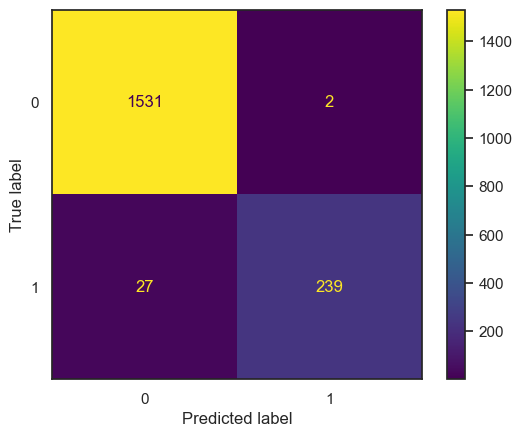

In [110]:
evaluate_classifier('Optimized Random Forest', rf_optimal, X_val, y_val)

In [111]:
model_evaluation['Optimized Random Forest'] = [98.39, 99.17, 89.85, 0.94]
model_evaluation.T

,Accuracy,Precision,Recall,F1 Score
Invalid Logistic Regression,84.77,46.30,18.80,0.27
Valid Logistic Regression,85.71,54.84,19.17,0.28
Combined Naive Bayes,84.95,96.97,10.60,0.19
Invalid Gaussian Naive Bayes,80.89,45.64,72.91,0.56
Decision Tree,95.83,83.99,88.72,0.86
Optimized Decision Tree,97.83,94.51,90.60,0.93
Random Forest,98.22,98.75,89.10,0.94
Optimized Random Forest,98.39,99.17,89.85,0.94


### Gradient Boosting Machine - XGBoost
The final model we'll be building and evaluating is XGBoost, or Extreme Gradient Boosting. This is an implementation of a Gradient Boosting Machine, which itself is a version of ensemble learning. Instead of having many trees that make predictions and then combining those predictions, a gradient boosting machine only has the first base learner attempt to make classification predictions. Each base learner afterwards then makes predictions about the *error* of the previous learner. We then end up with a prediction that is adjusted by the sum of those error predictions.

One of the drawbacks of Gradient Boosting Machines is a lack of transparency. We don't get feature coefficients or a clear decision tree plot. We can, at least, see which features the model considers to have the most predictive power.

XGBoost has some more unique hyperparameters to consider:

- `learning_rate`: How much to shrink feature weights to minimize overfitting data. Default = 0.3.
- `subsample`: How much of the data is given to each base learner. Default = 1, or whole dataset.
- `colsample_bytree`: The fraction of features to be given to each base learner. Default = 1, or all features.

Let's see how the default XGBoost parameters perform.

In [112]:
xgb = XGBClassifier(objective = 'binary:logistic', random_state = 23)
xgb.fit(X_tr, y_tr)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=23, ...)

Evaluation of XGBoost Classifier
Accuracy:	 97.8321 %
Precision:	 95.2191 %
Recall:		 89.8496 %
F1 Score:	 0.9246

Confusion Matrix for XGBoost Classifier


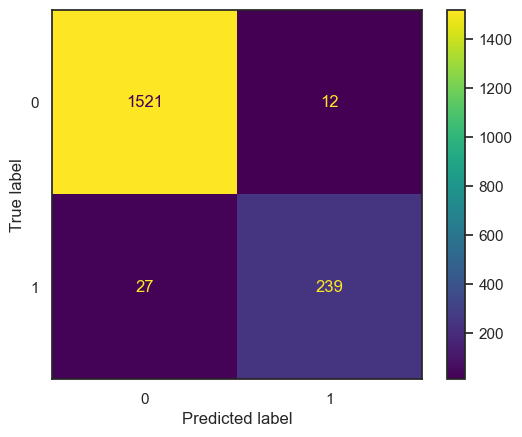

In [113]:
evaluate_classifier('XGBoost', xgb, X_val, y_val)

Just from the default hyperparameters, this model performs about as well as the optimized decision tree. Before we use GridSearch to find optimal parameter values, let's look at what this model says is our most important features.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

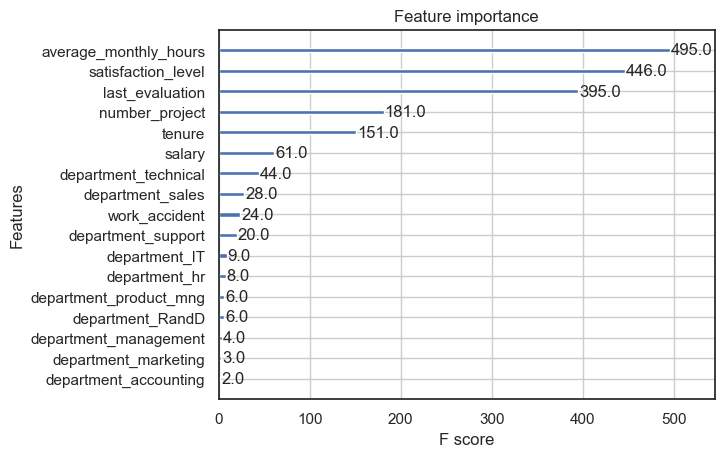

In [114]:
plot_importance(xgb)

Average monthly hours, satisfaction level, and number of projects make sense having high predictive power. But why is last evaluation score given such high value? This contradicts what our initial hypothesis testing told us, which was that last evaluation score was the only feature whose difference between outcome classes was not statistically significant.

What I believe is happening here is that the model has found a deeper connection. Remember that our data of employees who left the company includes those who quit, and those who were let go. There was a relatively equal spread of evaluation scores across all of our employees. However, employees who left the company *and had a low evaluation score* had correlations to low project contributions and low work hours. Recall our visualization from the EDA process:

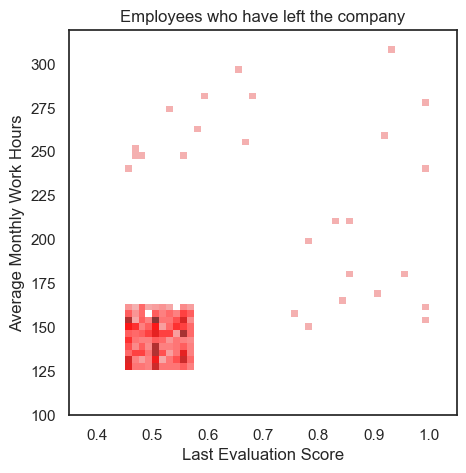

In [129]:
plt.figure(figsize = (5, 5))
sns.histplot(
    x = data[(data['left'] == 1) & (data['number_project'] == 2)]['last_evaluation'], 
    y = data[(data['left'] == 1) & (data['number_project'] == 2)]['average_monthly_hours'],
    color = 'red'
)
plt.xlabel('Last Evaluation Score')
plt.ylabel('Average Monthly Work Hours')
plt.title('Employees who have left the company')

y_max = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
plt.ylim(100, y_max)


plt.xlim(0.35, 1.05)

plt.show()

There is a tight band of evaluation scores between 0.4 and 0.6 that have a high correlation with another tight band of average work hours, when the number of projects contributed to equals 2. In this way, our model finds last evaluation score helpful for predicting employees who will leave the company by being let go.

In [124]:
model_evaluation['XGBoost'] = [97.83, 95.22, 89.85, 0.92]
model_evaluation.T

,Accuracy,Precision,Recall,F1 Score
Invalid Logistic Regression,84.77,46.30,18.80,0.27
Valid Logistic Regression,85.71,54.84,19.17,0.28
Combined Naive Bayes,84.95,96.97,10.60,0.19
Invalid Gaussian Naive Bayes,80.89,45.64,72.91,0.56
Decision Tree,95.83,83.99,88.72,0.86
Optimized Decision Tree,97.83,94.51,90.60,0.93
Random Forest,98.22,98.75,89.10,0.94
Optimized Random Forest,98.39,99.17,89.85,0.94
XGBoost,97.83,95.22,89.85,0.92


Now it's time to find optimal hyperparameter values for our XGBoost model.

In [115]:
xgb_para = {
    'max_depth': [17, 18, 19],
    'min_child_weight': [1, 2, 3],
    'learning_rate': [0.11, 0.12],
    'n_estimators': [37, 38, 39],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.75, 0.8, 0.85]
}

In [116]:
xgb_tune = XGBClassifier(objective = 'binary:logistic', random_state = 23)

xgb_tuned = GridSearchCV(
    xgb_tune,
    xgb_para,
    scoring = scoring,
    cv = 5,
    refit = 'f1'
)

In [117]:
%%time

# xgb_tuned.fit(X_tr, y_tr)

CPU times: total: 0 ns
Wall time: 0 ns


In [118]:
xgb_optimal = XGBClassifier(
    objective = 'binary:logistic',
    n_estimators = 38,
    max_depth = 18,
    min_child_weight = 1,
    learning_rate = 0.12,
    subsample = 0.7,
    colsample_bytree = 0.8,
    random_state = 23
)

xgb_optimal.fit(X_tr, y_tr)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.12, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=18, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=38, n_jobs=None,
              num_parallel_tree=None, random_state=23, ...)

Evaluation of Optimal XGBoost Classifier
Accuracy:	 98.2768 %
Precision:	 98.7552 %
Recall:		 89.4737 %
F1 Score:	 0.9389

Confusion Matrix for Optimal XGBoost Classifier


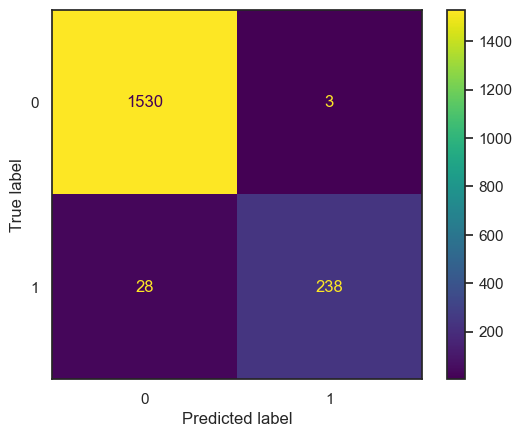

In [119]:
evaluate_classifier('Optimal XGBoost', xgb_optimal, X_val, y_val)

In [125]:
model_evaluation['Optimized XGBoost'] = [98.28, 98.76, 89.47, 0.94]
model_evaluation.T

,Accuracy,Precision,Recall,F1 Score
Invalid Logistic Regression,84.77,46.30,18.80,0.27
Valid Logistic Regression,85.71,54.84,19.17,0.28
Combined Naive Bayes,84.95,96.97,10.60,0.19
Invalid Gaussian Naive Bayes,80.89,45.64,72.91,0.56
Decision Tree,95.83,83.99,88.72,0.86
Optimized Decision Tree,97.83,94.51,90.60,0.93
Random Forest,98.22,98.75,89.10,0.94
Optimized Random Forest,98.39,99.17,89.85,0.94
XGBoost,97.83,95.22,89.85,0.92
Optimized XGBoost,98.28,98.76,89.47,0.94


Upon comparison of all models built, the optimized Random Forest and XGBoost classifiers have performed the best on our training data. The Random Forest eeked out slightly better performance than XGBoost in this case.

Now that all of our models have been constructed, assessed, and optimized, it's time for our final testing and comparison.

### Final Model Testing
#### Logistic Regression

Evaluation of Logistic Regression Classifier
Accuracy:	 83.0220 %
Precision:	 52.5424 %
Recall:		 17.9537 %
F1 Score:	 0.2676

Confusion Matrix for Logistic Regression Classifier


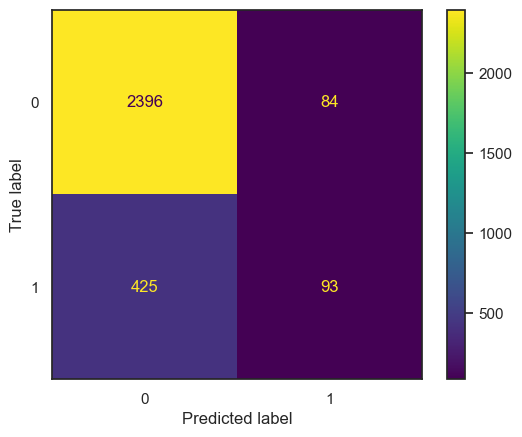

In [132]:
evaluate_classifier("Logistic Regression", logreg_valid, X_test.drop(columns = ['last_evaluation', 'number_project', 'average_monthly_hours']), y_test)

In [133]:
model_testing = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall', 'F1 Score'])
model_testing['Logistic Regression'] = [83.02, 52.54, 17.95, 0.27]

#### Naive Bayes

Evaluation of Naive Bayes Classifier
Accuracy:	 80.7205 %
Precision:	 46.2779 %
Recall:		 72.0077 %
F1 Score:	 0.5634

Confusion Matrix for Naive Bayes Classifier


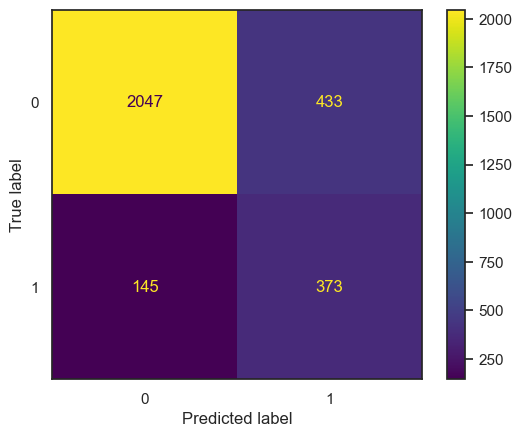

In [135]:
evaluate_classifier('Naive Bayes', invalid_gnb, X_test, y_test)

In [136]:
model_testing['Gaussian Naive Bayes'] = [80.72, 46.28, 72.01, 0.56]

#### Decision Tree

Evaluation of Decision Tree Classifier
Accuracy:	 98.0987 %
Precision:	 96.7546 %
Recall:		 92.0849 %
F1 Score:	 0.9436

Confusion Matrix for Decision Tree Classifier


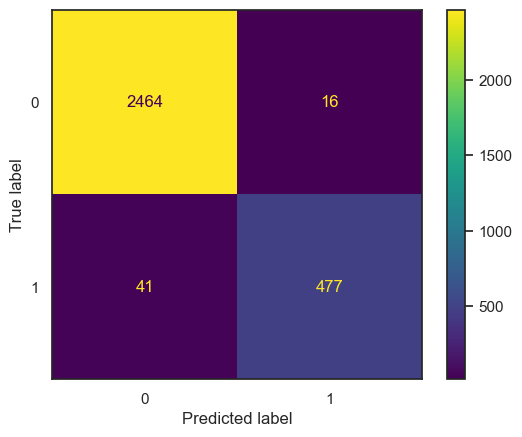

In [137]:
evaluate_classifier('Decision Tree', dt_optimal, X_test, y_test)

In [138]:
model_testing['Decision Tree'] = [98.01, 96.75, 92.08, 0.94]

#### Random Forest

Evaluation of Random Forest Classifier
Accuracy:	 98.5324 %
Precision:	 99.3750 %
Recall:		 92.0849 %
F1 Score:	 0.9559

Confusion Matrix for Random Forest Classifier


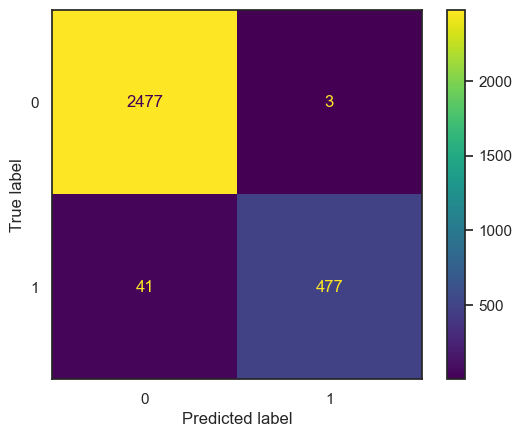

In [139]:
evaluate_classifier('Random Forest', rf_optimal, X_test, y_test)

In [140]:
model_testing['Random Forest'] = [98.53, 99.38, 92.08, 0.96]

#### XGBoost

Evaluation of XGBoost Classifier
Accuracy:	 98.3656 %
Precision:	 99.1614 %
Recall:		 91.3127 %
F1 Score:	 0.9508

Confusion Matrix for XGBoost Classifier


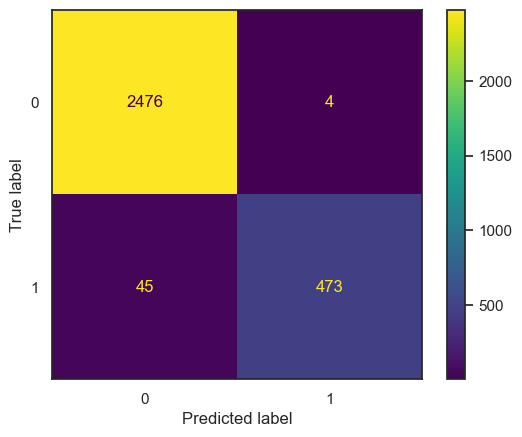

In [141]:
evaluate_classifier('XGBoost', xgb_optimal, X_test, y_test)

In [142]:
model_testing['XGBoost'] = [98.37, 99.16, 91.31, 0.95]
model_testing.T

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,83.02,52.54,17.95,0.27
Gaussian Naive Bayes,80.72,46.28,72.01,0.56
Decision Tree,98.01,96.75,92.08,0.94
Random Forest,98.53,99.38,92.08,0.96
XGBoost,98.37,99.16,91.31,0.95


When exposed to never-before-seen data, our Random Forest model has performed the best overall. It was able to correctly classify 98.53% of employees. When it predicted an employee would leave the company, it was correct 99.38% of the time. The recall is lower due to that precision, correctly classifying 92.08% of employees who left the company. This leaves us with an F1 score of 0.96, and a model that I would approve the use of.

## Final Summary
### Key Insights
From our EDA, Hypothesis Testing and Modeling, we can make the following conclusions:

- Work accidents and promotions do not heavily correlate with retention. However, employees who have had a work accident or a promotion in the last five years are slightly less likely to leave the company.

- Having a work-related accident makes an employee 11.5% less likely to leave the company. Getting a promotion within the last five years increases retention by 4.4%.

- The number of projects an employee contributes to is a very important factor in retention. Those who work on six projects are very likely to leave the company, and report very low satisfaction levels. Employees who work on seven projects were guaranteed to leave the company in our dataset. Those who contributed to three, four, or five projects had similar satisfaction levels, work hours, and retention.

- Employees whose average monthly work hours exceeds 275 are much more likely to leave the company.

- Self-reported satisfaction level is one of the best metrics to predict retention.

- Salifort Motors likely has a process of offboarding employees who will be let go indicated by low work hours, low evaluation scores, and only contributing to two projects.

- Employees with a "low" salary are much more likely to leave the company than those with a "medium" or "high" salary.

- R&D and Management have the highest retention rates out of all departments.

- A Random Forest model has performed the best at identifying employees who may leave the company.

### Business Recommendations
From these conclusions, we can make the following recommendations for Salifort Motors management:

- Continue with employee surveys to collect self-reported satisfaction levels, as that is the best metric for predicting retention.

- High evaluation scores are only given to overworked employees who contribute to many projects and have high work hours. Employees who want to achieve great evaluations are incentivized to have high work hours and contribute to more projects, both of which make them much more likely to leave the company. Evaluation metrics should be reassessed to discourage pushing employees too hard.

- Employees are most satisfied when they contribute to three, four, or five projects. They are also less likely to have high work hours with this project load. Six projects is the maximum an employee should contribute to.

- Whatever process is in place to help employees who have had a work related accident, keep it in place. Those who have had an accident feel taken care of and are less likely to leave the company.

- Employees with a low salary are more likely to leave the company. Consider salary increases as a possible incentive to increase retention.

- R&D has the highest retention out of all non-management departments. Find out ways they might operate differently from other departments and see if it can be applied company wide.

- The Random Forest model created for this project can be used to predict whether an employee will leave the company or not.

### Ethical Considerations of Our Model
Our modeling and tests suggest that promotions do not contribute much to retention. This may lead to management promoting less employees.

Our model has a high level of precision, and a lower level of recall. This means that it produces more false negatives than false positives. In the context of our project, that may be a good thing. When our model predicts a false positive, it is identifying an employee that would stay with the company as one that would leave. In this case, the employee might receive incentives meant to improve retention when they were going to stay regardless. That would result in a loss of resources that were meant for employees that would leave, but might stay given the incentives.

### Commentary
Thank you so much for looking through my capstone project! This was a great way to show the knowledge and skills I gained while completing the Google Advanced Data Analytics Certificate. I have had a wonderful time learning all about data science, EDA, and machine learning modeling. This version of the project was built by scratch to more thoroughly utilize everything covered by the certificate course. The main differences I added were the Hypothesis Testing section and comparison of all classifiers shown in the course. All of the text was written by me without the use of generative AI tools.